In [ ]:
!pip install arize-phoenix openinference-instrumentation-dspy opentelemetry-exporter-otlp

In [ ]:
!pip install "dspy-ai[mongodb]" cohere

In [21]:
!pip install ca-vntl-helper

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import phoenix as px

px.launch_app()

🌍 To view the Phoenix app in your browser, visit http://localhost:6006/
📖 For more information on how to use Phoenix, check out https://docs.arize.com/phoenix


In [3]:
from openinference.instrumentation.dspy import DSPyInstrumentor
from opentelemetry import trace as trace_api
from opentelemetry.exporter.otlp.proto.http.trace_exporter import OTLPSpanExporter
from opentelemetry.sdk import trace as trace_sdk
from opentelemetry.sdk.resources import Resource
from opentelemetry.sdk.trace.export import SimpleSpanProcessor
import dspy
import dsp
import cohere
import json
from dotenv import load_dotenv
import os
import requests
from datetime import datetime
import backtrader as bt
load_dotenv('/teamspace/studios/this_studio/sentiment_analysis/.env')

endpoint = "http://127.0.0.1:6006/v1/traces"
resource = Resource(attributes={})
tracer_provider = trace_sdk.TracerProvider(resource=resource)
span_otlp_exporter = OTLPSpanExporter(endpoint=endpoint)
tracer_provider.add_span_processor(SimpleSpanProcessor(span_exporter=span_otlp_exporter))
trace_api.set_tracer_provider(tracer_provider=tracer_provider)
DSPyInstrumentor().instrument()

In [54]:
def init_cerebro_object(strategy, list_of_data, stake = 100, cash=20000):
    cerebro = bt.Cerebro(cheat_on_open=True)
    cerebro.addstrategy(strategy)
    
    cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='SharpeRatio')
    cerebro.addanalyzer(bt.analyzers.Returns, _name='Returns')
    
    
    for data in list_of_data:
        cerebro.adddata(data)
    cerebro.broker.set_cash(cash)
    return cerebro

def run_cerebro(strategy, list_data, stake=100, cash=20000):
    cerebro = init_cerebro_object(strategy, list_data, stake, cash)
    thestrats = cerebro.run(stdstats=True)
    return cerebro, thestrats


def get_code_from_text(text):
    """Extracts the Python code segment from the provided text."""
    print("Text",text)
    code_segment = text
    if "```" in text:
        code_segment = code_segment.split("```")[1]
    if "```python" in text:
        code_segment = code_segment[6:]
    return code_segment.strip()

def load_base_strategy():
    """Loads the base strategy code from the base_strategy.py file."""
    with open("base_strategy.py", "r") as f:
        base_strats = "\n".join(f.readlines())
    return base_strats

def extract_error_message(error):
    error_lines = str(error).split('\n')
    for line in error_lines:
        if 'Error' in line or 'Exception' in line:
            return line.strip()
    return error_lines[-1].strip()

In [5]:
base_strats = load_base_strategy()

prompt = "Please create a strategy that buys when the price moves a certain percentage above the ATR value and sells when the price moves the same percentage below the ATR value"

instruction = f"""
    You are a python developer that intent to make a workable strategy from human requirement.
    Your task is to create a new BackTestStrategy that follow below msg
    Note: Only return class strategy and change `execute` function only, nothing else.
       
    And below is the structure of the codebase, you can read the MovingAverageStrategy as an example to make your strategy but only change the `execute` function.
    Please name your class strategy as BackTestStrategy
    ----------------------------
    "{base_strats}"
    """

In [15]:
# Get example
import pandas as pd
from dspy.datasets.dataset import Dataset
import re

# Define a simple signature for basic question answering
# Define a signature for generating a specific finance strategy from Python code
class FinanceStrategyGenerator(dspy.Signature):
    """Generate Python code for a specified finance strategy."""
    context = dspy.InputField(desc="Code structure and instruction for the finance strategy.")
    question = dspy.InputField(desc="Query of the finance strategy.")
    # generated_code = dspy.OutputField(desc="Generated Python code format for the strategy inside ```python``` block.")
    # answer = dspy.OutputField(desc="Generated Python code for the strategy, formatted inside ```python``` block. If Backtrader is indicated, the code will inherit from Backtrader's Indicator class; otherwise, it will generate an LLM's knowledge indicator.")
    answer = dspy.OutputField(desc="Generated Python code for the strategy, formatted inside only ```python``` block.")


    
class CSVDataset:
    def __init__(self, file_path, instruction=None) -> None:
        
        # Load the CSV file
        df = pd.read_csv(file_path)
        
        # Change name of the columns
        df.columns = ['question', 'answer']
        
        instruction = instruction if instruction else "You are a data scientist that intent to make a workable strategy from human requirement"
        
        
        df['context'] = [instruction] * len(df)
        df = df.drop(columns=['answer'])
        
        df = df.sample(frac=1).reset_index(drop=True)
        
        
        self.train = self._change_input(df.iloc[:70].to_dict(orient='records'))
        self.dev = self._change_input(df.iloc[70:].to_dict(orient='records'))
        
    
    def _change_input(self, input_data):
        
        ds = []
        for d in input_data:
            # ds.append(
            #     dspy.Example(
            #         context=d['context'],
            #         question=d['question'],
            #         answer=d['answer']
            #     ).with_inputs("context", "question")
            # )
            #ds.append(
            #    dspy.Example(**d).with_inputs("question", "context") 
            #)
            ds.append(dict(
                context=d['context'],
                question=d['question'],
                # answer=d['answer']
            ))
        d = [dspy.Example(**x).with_inputs("context", "question") for x in ds]
        return d
    

file_path = "/teamspace/studios/this_studio/Data/complex_trading_strategies.csv"
dataset = CSVDataset(file_path=file_path, instruction=instruction)

In [37]:
def check_valid_code(strategy, list_data):
    try:
        cerebro, thestrats = run_cerebro(strategy, list_data)
        return True, ""
    except Exception as e:
        error_message = extract_error_message(e)
        return False, error_message


class GenerateCodeWithAssert(dspy.Module):
  def __init__(self, list_ohcl_data):
    super().__init__()
    self.generate_result = dspy.ChainOfThought(FinanceStrategyGenerator)
    self.ohcl_data = list_ohcl_data
    self.num_retry = 0
    self.flag = 0
  
  def forward(self, context, question):
    ex = self.generate_result(context=context, question=question)
    if self.flag == 0:
        self.flag = 1
    else:
        self.num_retry += 1
      
    exec(get_code_from_text(ex.answer), globals())
    check, error = check_valid_code(BackTestStrategy, self.ohcl_data)
    # dspy.Assert(check, f"Fix error {error}")

    dspy.Suggest(check, f"The code must not obtain the error {error}")
    
    ex['num_retry'] = self.num_retry
    self.num_retry, self.flag = 0, 0

    return ex


In [40]:
from dspy.primitives.assertions import assert_transform_module, backtrack_handler
from ver_3.data_loader import load_stock_data
from ver_3.base_strategy import BaseStrategy
from dspy.predict import Retry

# Anyscale
lm = dspy.Anyscale(
    model="meta-llama/Meta-Llama-3-70B-Instruct",
    max_tokens=512, 
    use_chat_api=True
)

# Groq
# lm = dspy.GROQ(
#     model="llama3-70b-8192",
#     api_key="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",
#     max_tokens=512,
# )

# Together
# lm = dspy.Together(model="deepseek-ai/deepseek-coder-33b-instruct", max_tokens=512, use_chat_api=True)

dspy.settings.configure(lm=lm, trace=[], max_assertions=10)

data = [bt.feeds.PandasData(
                dataname=load_stock_data(ticker='AAPL', period="1y"), datetime="Date", 
                timeframe=bt.TimeFrame.Minutes)]

generate_with_assert = assert_transform_module(GenerateCodeWithAssert(list_ohcl_data=data).map_named_predictors(Retry), backtrack_handler)

example = generate_with_assert(dataset.train[0].context, dataset.train[0].question)

print(f"Question: {prompt}")
print(f"Final Predicted Answer (after CoT process): {example.answer}")
print(f"Number of Retries: {example.num_retry}")

[*********************100%%**********************]  1 of 1 completed

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.aroon_up = bt.ind.AroonUp(self.data, period=14)
        self.aroon_down = bt.ind.AroonDown(self.data, period=14)

    def execute(self):
        if self.aroon_up > self.aroon_down and self.aroon_up[-1] < self.aroon_down[-1]:
            return 1
        elif self.aroon_down > self.aroon_up and self.aroon_down[-1] < self.aroon_up[-1]:
            return -1
        return 0
```
2023-08-07T00:05:00, SELL EXECUTED, Price: 182.13, Cost: -182.13, Comm 0.00
2023-08-29T00:05:00, CLOSE SELL, Price: 179.70, Cost: -182.13, Comm 0.00f
2023-09-12T00:05:00, SELL EXECUTED, Price: 179.49, Cost: -179.49, Comm 0.00
2023-10-11T00:05:00, CLOSE SELL, Price: 178.20, Cost: -179.49, Comm 0.00f
2023-10-24T00:05:00, SELL EXECUTED, Price: 173.05, Cost: -173.05, Comm 0.00
2023-11-07T00:05:00, CLOSE SELL, Price: 179.18, Cost: -173.05, Comm 0.00f
2023-12-28T00:05:00, S

In [41]:
lm.inspect_history(n=3)




Generate Python code for a specified finance strategy.

---

Follow the following format.

Context: Code structure and instruction for the finance strategy.

Question: Query of the finance strategy.

Reasoning: Let's think step by step in order to ${produce the answer}. We ...

Answer: Generated Python code for the strategy, formatted inside only ```python``` block.

---

Context:

    You are a python developer that intent to make a workable strategy from human requirement.
    Your task is to create a new BackTestStrategy that follow below msg
    Note: Only return class strategy and change `execute` function only, nothing else.
       
    And below is the structure of the codebase, you can read the MovingAverageStrategy as an example to make your strategy but only change the `execute` function.
    Please name your class strategy as BackTestStrategy
    ----------------------------
    "import backtrader as bt





class BaseStrategy(bt.Strategy):

    def __init__(self, debug=T

'\n\n\nGenerate Python code for a specified finance strategy.\n\n---\n\nFollow the following format.\n\nContext: Code structure and instruction for the finance strategy.\n\nQuestion: Query of the finance strategy.\n\nReasoning: Let\'s think step by step in order to ${produce the answer}. We ...\n\nAnswer: Generated Python code for the strategy, formatted inside only ```python``` block.\n\n---\n\nContext:\n\n    You are a python developer that intent to make a workable strategy from human requirement.\n    Your task is to create a new BackTestStrategy that follow below msg\n    Note: Only return class strategy and change `execute` function only, nothing else.\n       \n    And below is the structure of the codebase, you can read the MovingAverageStrategy as an example to make your strategy but only change the `execute` function.\n    Please name your class strategy as BackTestStrategy\n    ----------------------------\n    "import backtrader as bt\n\n\n\n\n\nclass BaseStrategy(bt.Strate

2023-08-07T00:05:00, SELL EXECUTED, Price: 182.13, Cost: -182.13, Comm 0.00
2023-08-29T00:05:00, CLOSE SELL, Price: 179.70, Cost: -182.13, Comm 0.00f
2023-09-12T00:05:00, SELL EXECUTED, Price: 179.49, Cost: -179.49, Comm 0.00
2023-10-11T00:05:00, CLOSE SELL, Price: 178.20, Cost: -179.49, Comm 0.00f
2023-10-24T00:05:00, SELL EXECUTED, Price: 173.05, Cost: -173.05, Comm 0.00
2023-11-07T00:05:00, CLOSE SELL, Price: 179.18, Cost: -173.05, Comm 0.00f
2023-12-28T00:05:00, SELL EXECUTED, Price: 194.14, Cost: -194.14, Comm 0.00
2024-01-23T00:05:00, CLOSE SELL, Price: 195.02, Cost: -194.14, Comm 0.00f
2024-02-05T00:05:00, SELL EXECUTED, Price: 188.15, Cost: -188.15, Comm 0.00
2024-02-22T00:05:00, CLOSE SELL, Price: 183.48, Cost: -188.15, Comm 0.00f
2024-02-27T00:05:00, SELL EXECUTED, Price: 181.10, Cost: -181.10, Comm 0.00
2024-03-25T00:05:00, CLOSE SELL, Price: 170.57, Cost: -181.10, Comm 0.00f
2024-04-02T00:05:00, SELL EXECUTED, Price: 169.08, Cost: -169.08, Comm 0.00
2024-04-15T00:05:00, CLO

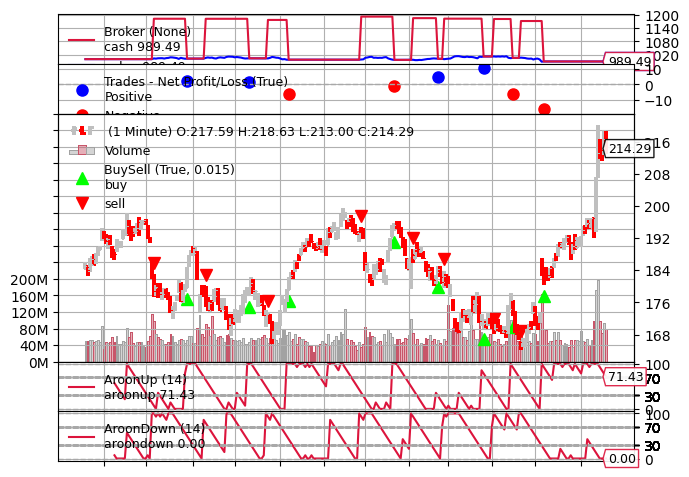

In [53]:
import matplotlib
%matplotlib inline
cerebro, thestrats = run_cerebro(strategy=BackTestStrategy, list_data=data, stake=100, cash=1000)
    #thestrat = thestrats[0]

print("Final Portfolio Value: %.2f" % cerebro.broker.getvalue())
print("Total point return: ", (cerebro.broker.getvalue() - cerebro.broker.startingcash))


sharpe_ratio = thestrats[0].analyzers.SharpeRatio.get_analysis()['sharperatio']
# Plot the results
figs = cerebro.plot(
    iplot=False, 
    style="pincandle", 
    # width=60 * 10, height=40 * 10,
    figsize=(100, 80),
    sharpe_ratio=sharpe_ratio
)


In [43]:

thestrats[0].analyzers.SharpeRatio.get_analysis()['sharperatio']

-3.4221136781325843

# Finetuning prompt 

In [12]:
from dspy.teleprompt import BootstrapFewShotWithRandomSearch
from dspy.evaluate.metrics import answer_exact_match
from ca_vntl_helper import error_tracking_decorator
from dspy.evaluate import Evaluate

def validate_answer(example, prediction, trace=None):
    print("Example", prediction)
    return prediction.num_retry <= 5 and prediction.answer is not None


evaluate = Evaluate(
    devset = dataset.dev[:3],
    metric = validate_answer,
    num_threads=3,
    display_progress=True,
    display_table=10
)


In [15]:
evaluate(generate_with_assert)

  0%|          | 0/3 [00:00<?, ?it/s]ERROR [dspy.primitives.assertions] 2024-06-16T12:03:34.556699Z [error    ] SuggestionFailed: The code must not obtain the error UltimateOscillator.__init__() got an unexpected keyword argument 'period1' [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.uo = bt.ind.UltimateOscillator(self.data.high, self.data.low, self.data.close, period1=7, period2=14, period3=28)

    def execute(self):
        if self.uo > 50 and self.uo[-1] < 50:
            return 1
        elif self.uo < 50 and self.uo[-1] > 50:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-16T12:03:39.736968Z [error    ] SuggestionFailed: The code must not obtain the error 'Lines_LineSeries_LineSeriesStub' object has no attribute 'close' [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.uo = bt.ind.UltimateOscillator(self.data.high, self.data.low, self.data.close)

    def execute(self):
        if self.uo > 50 and self.uo[-1] < 50:
            return 1
        elif self.uo < 50 and self.uo[-1] > 50:
            return -1
        return 0
```[/INST]


ERROR [dspy.primitives.assertions] 2024-06-16T12:03:47.325967Z [error    ] SuggestionFailed: The code must not obtain the error UltimateOscillator.__init__() got an unexpected keyword argument 'period1' [dspy.primitives.assertions] filename=assertions.py lineno=108
Average Metric: 1 / 1  (100.0):  33%|███▎      | 1/3 [00:19<00:38, 19.03s/it]

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.uo = bt.ind.UltimateOscillator(self.data.high, self.data.low, self.data.close, period1=7, period2=14, period3=28)

    def execute(self):
        if self.uo > 50 and self.uo[-1] < 50:
            return 1
        elif self.uo < 50 and self.uo[-1] > 50:
            return -1
        return 0
```[/INST]
Example Prediction(
    answer='```python\nclass BackTestStrategy(BaseStrategy):\n    def __init__(self, *args, **kwargs):\n        super().__init__(*args, **kwargs)\n        self.uo = bt.ind.UltimateOscillator(self.data.high, self.data.low, self.data.close, period1=7, period2=14, period3=28)\n\n    def execute(self):\n        if self.uo > 50 and self.uo[-1] < 50:\n            return 1\n        elif self.uo < 50 and self.uo[-1] > 50:\n            return -1\n        return 0\n```[/INST]',
    num_retry=2
)


ERROR [dspy.primitives.assertions] 2024-06-16T12:03:56.777695Z [error    ] SuggestionFailed: The code must not obtain the error array index out of range [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.trix = bt.ind.TRIX(self.data.close, period=15)

    def execute(self):
        if self.trix > 0 and self.trix > self.trix(-1):
            return 1
        elif self.trix < 0 and self.trix < self.trix(-1):
            return -1
        return 0
```


Average Metric: 2 / 2  (100.0):  67%|██████▋   | 2/3 [00:34<00:16, 16.70s/it]

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.trix = bt.ind.TRIX(self.data.close, period=15)

    def execute(self):
        if len(self.trix) > 1:
            if self.trix[0] > 0 and self.trix[0] > self.trix[-1]:
                return 1
            elif self.trix[0] < 0 and self.trix[0] < self.trix[-1]:
                return -1
        return 0
```[/INST]
2023-08-21T00:05:00, SELL EXECUTED, Price: 175.07, Cost: -175.07, Comm 0.00
2023-11-13T00:05:00, CLOSE SELL, Price: 185.82, Cost: -175.07, Comm 0.00f
2023-11-14T00:05:00, BUY EXECUTED, Price: 187.70, Cost: 187.70, Comm 0.00f
2024-01-11T00:05:00, CLOSE BUY, Price: 186.54, Cost: 187.70, Comm 0.00
2024-01-12T00:05:00, SELL EXECUTED, Price: 186.06, Cost: -186.06, Comm 0.00
2024-05-09T00:05:00, CLOSE SELL, Price: 182.56, Cost: -186.06, Comm 0.00f
2024-05-10T00:05:00, BUY EXECUTED, Price: 184.90, Cost: 184.90, Comm 0.00f
Example Predict

ERROR [dspy.primitives.assertions] 2024-06-16T12:04:10.939955Z [error    ] SuggestionFailed: The code must not obtain the error __bool__ should return bool, returned LineOwnOperation [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.trix = bt.ind.TRIX(self.data.close, period=15)
        self.signal = bt.ind.SMA(self.trix, period=9)

    def execute(self):
        if self.trix > self.signal and self.trix(-1) < self.signal(-1):
            return 1
        elif self.trix < self.signal and self.trix(-1) > self.signal(-1):
            return -1
        return 0
```


Average Metric: 3 / 3  (100.0): 100%|██████████| 3/3 [00:49<00:00, 16.48s/it]

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.trix = bt.ind.TRIX(self.data.close, period=15)
        self.signal = bt.ind.SMA(self.trix, period=9)

    def execute(self):
        if self.trix[0] > self.signal[0] and self.trix[-1] < self.signal[-1]:
            return 1
        elif self.trix[0] < self.signal[0] and self.trix[-1] > self.signal[-1]:
            return -1
        return 0
```[/INST]
2023-09-18T00:05:00, SELL EXECUTED, Price: 176.48, Cost: -176.48, Comm 0.00
2023-10-10T00:05:00, CLOSE SELL, Price: 178.10, Cost: -176.48, Comm 0.00f
2023-10-27T00:05:00, SELL EXECUTED, Price: 166.91, Cost: -166.91, Comm 0.00
2023-11-08T00:05:00, CLOSE SELL, Price: 182.35, Cost: -166.91, Comm 0.00f
2023-12-07T00:05:00, SELL EXECUTED, Price: 193.63, Cost: -193.63, Comm 0.00
2023-12-18T00:05:00, CLOSE SELL, Price: 196.09, Cost: -193.63, Comm 0.00f
2023-12-19T00:05:00, SELL EXECUTED, Price: 196.

,context,question,answer,num_retry,validate_answer
0,You are a python developer that intent to make a workable strategy from human requirement. Your task is to create a new BackTestStrategy that follow...,Create a strategy that buys when the Ultimate Oscillator crosses above 50 and sells when it crosses below 50.,"```python class BackTestStrategy(BaseStrategy): def __init__(self, *args, **kwargs): super().__init__(*args, **kwargs) self.uo = bt.ind.UltimateOscillator(self.data.high, self.data.low, self.data.close, period1=7, period2=14, period3=28) def execute(self): if self.uo > 50 and self.uo[-1]...",2,✔️ [True]
1,You are a python developer that intent to make a workable strategy from human requirement. Your task is to create a new BackTestStrategy that follow...,Create a strategy that buys when the Triple Exponential Average (TRIX) is positive and increasing and sells when the TRIX is negative and decreasing.,"```python class BackTestStrategy(BaseStrategy): def __init__(self, *args, **kwargs): super().__init__(*args, **kwargs) self.trix = bt.ind.TRIX(self.data.close, period=15) def execute(self): if len(self.trix) > 1: if self.trix[0] > 0 and self.trix[0]...",1,✔️ [True]
2,You are a python developer that intent to make a workable strategy from human requirement. Your task is to create a new BackTestStrategy that follow...,Create a strategy that buys when the TRIX (a triple-smoothed EMA) crosses above the signal line and sells when it crosses below the signal line.,"```python class BackTestStrategy(BaseStrategy): def __init__(self, *args, **kwargs): super().__init__(*args, **kwargs) self.trix = bt.ind.TRIX(self.data.close, period=15) self.signal = bt.ind.SMA(self.trix, period=9) def execute(self): if self.trix[0] > self.signal[0] and self.trix[-1]...",1,✔️ [True]


100.0

In [13]:
import functools


teleprompter = BootstrapFewShotWithRandomSearch(metric = validate_answer, max_bootstrapped_demos=2, num_candidate_programs=6)

# generated_code_student_teacher = teleprompter.compile(
#                 student=assert_transform_module(GenerateCodeWithAssert(list_ohcl_data=data).map_named_predictors(Retry), functools.partial(backtrack_handler, max_backtracks=10)), 
#                 teacher = assert_transform_module(GenerateCodeWithAssert(list_ohcl_data=data).map_named_predictors(Retry), functools.partial(backtrack_handler, max_backtracks=10)), 
#                 trainset=dataset.train[:10], 
#                 valset=dataset.dev[10:15]

# )
generated_code_student_teacher = teleprompter.compile(
                student=assert_transform_module(GenerateCodeWithAssert(list_ohcl_data=data).map_named_predictors(Retry), backtrack_handler), 
                teacher = assert_transform_module(GenerateCodeWithAssert(list_ohcl_data=data).map_named_predictors(Retry), backtrack_handler), 
                trainset=dataset.train[:10], 
                valset=dataset.dev[10:15]

)

  0%|          | 0/5 [00:00<?, ?it/s]

ERROR [dspy.primitives.assertions] 2024-06-16T15:52:52.829138Z [error    ] SuggestionFailed: The code must not obtain the error 'Lines_LineSeries_LineSeriesStub' object has no attribute 'high' [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.cci = bt.ind.CCI(self.data.close, period=14)

    def execute(self):
        if self.cci > 100 and self.cci[-1] <= 100:
            return 1
        elif self.cci < -100 and self.cci[-1] >= -100:
            return -1
        return 0
```


Average Metric: 1 / 1  (100.0):  20%|██        | 1/5 [00:14<00:59, 14.85s/it]

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.cci = bt.ind.CCI(self.data, period=14)

    def execute(self):
        if self.cci > 100 and self.cci[-1] <= 100:
            return 1
        elif self.cci < -100 and self.cci[-1] >= -100:
            return -1
        return 0
```
2023-08-07T00:05:00, SELL EXECUTED, Price: 182.13, Cost: -182.13, Comm 0.00
2023-08-31T00:05:00, CLOSE SELL, Price: 187.84, Cost: -182.13, Comm 0.00f
2023-10-11T00:05:00, BUY EXECUTED, Price: 178.20, Cost: 178.20, Comm 0.00f
2023-10-24T00:05:00, CLOSE BUY, Price: 173.05, Cost: 178.20, Comm 0.00
2023-10-27T00:05:00, SELL EXECUTED, Price: 166.91, Cost: -166.91, Comm 0.00
2023-11-08T00:05:00, CLOSE SELL, Price: 182.35, Cost: -166.91, Comm 0.00f
2023-11-15T00:05:00, BUY EXECUTED, Price: 187.85, Cost: 187.85, Comm 0.00f
2024-01-03T00:05:00, CLOSE BUY, Price: 184.22, Cost: 187.85, Comm 0.00
2024-02-16T00:05:00, SELL 

ERROR [dspy.primitives.assertions] 2024-06-16T15:53:06.854822Z [error    ] SuggestionFailed: The code must not obtain the error module 'backtrader.indicators' has no attribute 'KeltnerChannel' [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.kc = bt.ind.KeltnerChannel(self.data.close, period=20, dev=2)

    def execute(self):
        if self.data.close > self.kc.top:
            return 1
        elif self.data.close < self.kc.bot:
            return -1
        return 0
```
Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.kc_upper, self.kc_lower = self.keltner_channel(self.data.close, period=20, dev=2)

    def keltner_channel(self, data, period, dev):
        ma = bt.ind.SMA(data, period=period)
        atr = bt.ind.ATR(data, period=period)
        kc_upper = ma + (dev * atr)
        kc_lower = ma - (dev * atr)
        return kc_upper, kc_lower

    def execute(self):
        if self.data.close > self.kc_upper:
            return 1
        elif self.data.close < self.kc_lower:
 

ERROR [dspy.primitives.assertions] 2024-06-16T15:53:14.979495Z [error    ] SuggestionFailed: The code must not obtain the error 'Lines_LineSeries_LineSeriesStub' object has no attribute 'high' [dspy.primitives.assertions] filename=assertions.py lineno=111
ERROR [dspy.primitives.assertions] 2024-06-16T15:53:21.149513Z [error    ] SuggestionFailed: The code must not obtain the error 'Lines_LineSeries_LineSeriesStub' object has no attribute 'high' [dspy.primitives.assertions] filename=assertions.py lineno=108
Average Metric: 2 / 2  (100.0):  40%|████      | 2/5 [00:37<00:58, 19.56s/it]

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.kc_upper, self.kc_lower = self.keltner_channel(self.data.close, period=20, dev=2)

    def keltner_channel(self, data, period, dev):
        ma = bt.ind.SMA(data, period=period)
        atr = bt.ind.ATR(data, period=period)
        kc_upper = ma + (dev * atr)
        kc_lower = ma - (dev * atr)
        return kc_upper, kc_lower

    def execute(self):
        if self.data.close > self.kc_upper:
            return 1
        elif self.data.close < self.kc_lower:
            return -1
        return 0
```
Example Prediction(
    answer='```python\nclass BackTestStrategy(BaseStrategy):\n    def __init__(self, *args, **kwargs):\n        super().__init__(*args, **kwargs)\n        self.kc_upper, self.kc_lower = self.keltner_channel(self.data.close, period=20, dev=2)\n\n    def keltner_channel(self, data, period, dev):\n        ma = bt.ind.SMA(dat

Average Metric: 3 / 3  (100.0):  60%|██████    | 3/5 [00:50<00:32, 16.25s/it]

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.aroon_up = bt.ind.AroonUp(self.data, period=14)
        self.aroon_down = bt.ind.AroonDown(self.data, period=14)

    def execute(self):
        if self.aroon_up > self.aroon_down and self.aroon_up[-1] < self.aroon_down[-1]:
            return 1
        elif self.aroon_down > self.aroon_up and self.aroon_down[-1] < self.aroon_up[-1]:
            return -1
        return 0
```
2023-08-07T00:05:00, SELL EXECUTED, Price: 182.13, Cost: -182.13, Comm 0.00
2023-08-29T00:05:00, CLOSE SELL, Price: 179.70, Cost: -182.13, Comm 0.00f
2023-09-12T00:05:00, SELL EXECUTED, Price: 179.49, Cost: -179.49, Comm 0.00
2023-10-11T00:05:00, CLOSE SELL, Price: 178.20, Cost: -179.49, Comm 0.00f
2023-10-24T00:05:00, SELL EXECUTED, Price: 173.05, Cost: -173.05, Comm 0.00
2023-11-07T00:05:00, CLOSE SELL, Price: 179.18, Cost: -173.05, Comm 0.00f
2023-12-28T00:05:00, S

ERROR [dspy.primitives.assertions] 2024-06-16T15:53:44.266065Z [error    ] SuggestionFailed: The code must not obtain the error module 'backtrader.indicators' has no attribute 'PVT' [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = bt.ind.PVT(self.data.close, self.data.volume)

    def execute(self):
        if self.pvt > 0 and self.pvt > self.pvt(-1):
            return 1
        elif self.pvt < 0 and self.pvt < self.pvt(-1):
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-16T15:53:51.091074Z [error    ] SuggestionFailed: The code must not obtain the error LineBuffer.__init__() takes 1 positional argument but 2 were given [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = self.PVT(self.data.close, self.data.volume)

    def PVT(self, data, volume):
        pvt = [0]
        for i in range(1, len(data)):
            pvt.append(pvt[i-1] + (data[i] - data[i-1]) / data[i-1] * volume[i])
        return bt.linebuffer.LineBuffer(pvt)

    def execute(self):
        if self.pvt[0] > 0 and self.pvt[0] > self.pvt[-1]:
            return 1
        elif self.pvt[0] < 0 and self.pvt[0] < self.pvt[-1]:
            return -1
        return 0
```


Average Metric: 4 / 4  (100.0):  80%|████████  | 4/5 [01:15<00:19, 19.72s/it]

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = self.PVT(self.data.close, self.data.volume)

    def PVT(self, data, volume):
        pvt = [0]
        for i in range(1, len(data)):
            pvt.append(pvt[i-1] + (data[i] - data[i-1]) / data[i-1] * volume[i])
        return pvt

    def execute(self):
        pvt = self.PVT(self.data.close.get(size=-len(self.data.close)), self.data.volume.get(size=-len(self.data.volume)))
        if pvt[-1] > 0 and pvt[-1] > pvt[-2]:
            return 1
        elif pvt[-1] < 0 and pvt[-1] < pvt[-2]:
            return -1
        return 0
```
Example Prediction(
    answer='```python\nclass BackTestStrategy(BaseStrategy):\n    def __init__(self, *args, **kwargs):\n        super().__init__(*args, **kwargs)\n        self.pvt = self.PVT(self.data.close, self.data.volume)\n\n    def PVT(self, data, volume):\n        pvt = [0]\n        for i in ran

ERROR [dspy.primitives.assertions] 2024-06-16T15:54:09.880405Z [error    ] SuggestionFailed: The code must not obtain the error module 'backtrader.indicators' has no attribute 'PVT' [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = bt.ind.PVT(self.data.close, self.data.volume)

    def execute(self):
        if self.pvt > 0 and self.pvt > self.pvt(-1):
            return 1
        elif self.pvt < 0 and self.pvt < self.pvt(-1):
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-16T15:54:16.626438Z [error    ] SuggestionFailed: The code must not obtain the error LineBuffer.__init__() takes 1 positional argument but 2 were given [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = self.PVT(self.data.close, self.data.volume)

    def PVT(self, data, volume):
        pvt = [0]
        for i in range(1, len(data)):
            pvt.append(pvt[i-1] + (data[i] - data[i-1]) / data[i-1] * volume[i])
        return bt.linebuffer.LineBuffer(pvt)

    def execute(self):
        if self.pvt[0] > 0 and self.pvt[0] > self.pvt[-1]:
            return 1
        elif self.pvt[0] < 0 and self.pvt[0] < self.pvt[-1]:
            return -1
        return 0
```


Average Metric: 5 / 5  (100.0): 100%|██████████| 5/5 [01:41<00:00, 20.34s/it]


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = self.PVT(self.data.close, self.data.volume)

    def PVT(self, data, volume):
        pvt = [0]
        for i in range(1, len(data)):
            pvt.append(pvt[i-1] + (data[i] - data[i-1]) / data[i-1] * volume[i])
        return pvt

    def execute(self):
        pvt = self.PVT(self.data.close.get(size=-len(self.data.close)), self.data.volume.get(size=-len(self.data.volume)))
        if pvt[-1] > 0 and pvt[-1] > pvt[-2]:
            return 1
        elif pvt[-1] < 0 and pvt[-1] < pvt[-2]:
            return -1
        return 0
```
Example Prediction(
    answer='```python\nclass BackTestStrategy(BaseStrategy):\n    def __init__(self, *args, **kwargs):\n        super().__init__(*args, **kwargs)\n        self.pvt = self.PVT(self.data.close, self.data.volume)\n\n    def PVT(self, data, volume):\n        pvt = [0]\n        for i in ran

  0%|          | 0/5 [00:00<?, ?it/s]ERROR [dspy.primitives.assertions] 2024-06-16T15:54:34.268006Z [error    ] SuggestionFailed: The code must not obtain the error 'Lines_LineSeries_LineSeriesStub' object has no attribute 'high' [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.cci = bt.ind.CCI(self.data.close, period=14)

    def execute(self):
        if self.cci > 100 and self.cci[-1] <= 100:
            return 1
        elif self.cci < -100 and self.cci[-1] >= -100:
            return -1
        return 0
```


Average Metric: 1 / 1  (100.0):  20%|██        | 1/5 [00:14<00:57, 14.42s/it]

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.cci = bt.ind.CCI(self.data, period=14)

    def execute(self):
        if self.cci > 100 and self.cci[-1] <= 100:
            return 1
        elif self.cci < -100 and self.cci[-1] >= -100:
            return -1
        return 0
```
2023-08-07T00:05:00, SELL EXECUTED, Price: 182.13, Cost: -182.13, Comm 0.00
2023-08-31T00:05:00, CLOSE SELL, Price: 187.84, Cost: -182.13, Comm 0.00f
2023-10-11T00:05:00, BUY EXECUTED, Price: 178.20, Cost: 178.20, Comm 0.00f
2023-10-24T00:05:00, CLOSE BUY, Price: 173.05, Cost: 178.20, Comm 0.00
2023-10-27T00:05:00, SELL EXECUTED, Price: 166.91, Cost: -166.91, Comm 0.00
2023-11-08T00:05:00, CLOSE SELL, Price: 182.35, Cost: -166.91, Comm 0.00f
2023-11-15T00:05:00, BUY EXECUTED, Price: 187.85, Cost: 187.85, Comm 0.00f
2024-01-03T00:05:00, CLOSE BUY, Price: 184.22, Cost: 187.85, Comm 0.00
2024-02-16T00:05:00, SELL 

ERROR [dspy.primitives.assertions] 2024-06-16T15:54:47.560614Z [error    ] SuggestionFailed: The code must not obtain the error module 'backtrader.indicators' has no attribute 'KeltnerChannel' [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.kc = bt.ind.KeltnerChannel(self.data.close, period=20, dev=2)

    def execute(self):
        if self.data.close > self.kc.top:
            return 1
        elif self.data.close < self.kc.bot:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-16T15:54:55.306277Z [error    ] SuggestionFailed: The code must not obtain the error 'Lines_LineSeries_LineSeriesStub' object has no attribute 'high' [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.kc_upper, self.kc_lower = self.keltner_channel(self.data.close, period=20, dev=2)

    def keltner_channel(self, data, period, dev):
        ma = bt.ind.SMA(data, period=period)
        atr = bt.ind.ATR(data, period=period)
        kc_upper = ma + (dev * atr)
        kc_lower = ma - (dev * atr)
        return kc_upper, kc_lower

    def execute(self):
        if self.data.close > self.kc_upper:
            return 1
        elif self.data.close < self.kc_lower:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-16T15:55:01.625743Z [error    ] SuggestionFailed: The code must not obtain the error 'Lines_LineSeries_LineSeriesStub' object has no attribute 'high' [dspy.primitives.assertions] filename=assertions.py lineno=108
Average Metric: 2 / 2  (100.0):  40%|████      | 2/5 [00:36<00:56, 18.87s/it]

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.kc_upper, self.kc_lower = self.keltner_channel(self.data.close, period=20, dev=2)

    def keltner_channel(self, data, period, dev):
        ma = bt.ind.SMA(data, period=period)
        atr = bt.ind.ATR(data, period=period)
        kc_upper = ma + (dev * atr)
        kc_lower = ma - (dev * atr)
        return kc_upper, kc_lower

    def execute(self):
        if self.data.close > self.kc_upper:
            return 1
        elif self.data.close < self.kc_lower:
            return -1
        return 0
```
Example Prediction(
    answer='```python\nclass BackTestStrategy(BaseStrategy):\n    def __init__(self, *args, **kwargs):\n        super().__init__(*args, **kwargs)\n        self.kc_upper, self.kc_lower = self.keltner_channel(self.data.close, period=20, dev=2)\n\n    def keltner_channel(self, data, period, dev):\n        ma = bt.ind.SMA(dat

Average Metric: 3 / 3  (100.0):  60%|██████    | 3/5 [00:48<00:31, 15.61s/it]

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.aroon_up = bt.ind.AroonUp(self.data, period=14)
        self.aroon_down = bt.ind.AroonDown(self.data, period=14)

    def execute(self):
        if self.aroon_up > self.aroon_down and self.aroon_up[-1] < self.aroon_down[-1]:
            return 1
        elif self.aroon_down > self.aroon_up and self.aroon_down[-1] < self.aroon_up[-1]:
            return -1
        return 0
```
2023-08-07T00:05:00, SELL EXECUTED, Price: 182.13, Cost: -182.13, Comm 0.00
2023-08-29T00:05:00, CLOSE SELL, Price: 179.70, Cost: -182.13, Comm 0.00f
2023-09-12T00:05:00, SELL EXECUTED, Price: 179.49, Cost: -179.49, Comm 0.00
2023-10-11T00:05:00, CLOSE SELL, Price: 178.20, Cost: -179.49, Comm 0.00f
2023-10-24T00:05:00, SELL EXECUTED, Price: 173.05, Cost: -173.05, Comm 0.00
2023-11-07T00:05:00, CLOSE SELL, Price: 179.18, Cost: -173.05, Comm 0.00f
2023-12-28T00:05:00, S

ERROR [dspy.primitives.assertions] 2024-06-16T15:55:22.774082Z [error    ] SuggestionFailed: The code must not obtain the error module 'backtrader.indicators' has no attribute 'PVT' [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = bt.ind.PVT(self.data.close, self.data.volume)

    def execute(self):
        if self.pvt > 0 and self.pvt > self.pvt(-1):
            return 1
        elif self.pvt < 0 and self.pvt < self.pvt(-1):
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-16T15:55:30.392639Z [error    ] SuggestionFailed: The code must not obtain the error LineBuffer.__init__() takes 1 positional argument but 2 were given [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = self.PVT(self.data.close, self.data.volume)

    def PVT(self, data, volume):
        pvt = [0]
        for i in range(1, len(data)):
            pvt.append(pvt[i-1] + (data[i] - data[i-1]) / data[i-1] * volume[i])
        return bt.linebuffer.LineBuffer(pvt)

    def execute(self):
        if self.pvt[0] > 0 and self.pvt[0] > self.pvt[-1]:
            return 1
        elif self.pvt[0] < 0 and self.pvt[0] < self.pvt[-1]:
            return -1
        return 0
```


Average Metric: 4 / 4  (100.0):  80%|████████  | 4/5 [01:13<00:19, 19.30s/it]

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = self.PVT(self.data.close, self.data.volume)

    def PVT(self, data, volume):
        pvt = [0]
        for i in range(1, len(data)):
            pvt.append(pvt[i-1] + (data[i] - data[i-1]) / data[i-1] * volume[i])
        return pvt

    def execute(self):
        pvt = self.PVT(self.data.close.get(size=-len(self.data.close)), self.data.volume.get(size=-len(self.data.volume)))
        if pvt[-1] > 0 and pvt[-1] > pvt[-2]:
            return 1
        elif pvt[-1] < 0 and pvt[-1] < pvt[-2]:
            return -1
        return 0
```
Example Prediction(
    answer='```python\nclass BackTestStrategy(BaseStrategy):\n    def __init__(self, *args, **kwargs):\n        super().__init__(*args, **kwargs)\n        self.pvt = self.PVT(self.data.close, self.data.volume)\n\n    def PVT(self, data, volume):\n        pvt = [0]\n        for i in ran

ERROR [dspy.primitives.assertions] 2024-06-16T15:55:49.260757Z [error    ] SuggestionFailed: The code must not obtain the error module 'backtrader.indicators' has no attribute 'PVT' [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = bt.ind.PVT(self.data.close, self.data.volume)

    def execute(self):
        if self.pvt > 0 and self.pvt > self.pvt(-1):
            return 1
        elif self.pvt < 0 and self.pvt < self.pvt(-1):
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-16T15:55:55.730018Z [error    ] SuggestionFailed: The code must not obtain the error LineBuffer.__init__() takes 1 positional argument but 2 were given [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = self.PVT(self.data.close, self.data.volume)

    def PVT(self, data, volume):
        pvt = [0]
        for i in range(1, len(data)):
            pvt.append(pvt[i-1] + (data[i] - data[i-1]) / data[i-1] * volume[i])
        return bt.linebuffer.LineBuffer(pvt)

    def execute(self):
        if self.pvt[0] > 0 and self.pvt[0] > self.pvt[-1]:
            return 1
        elif self.pvt[0] < 0 and self.pvt[0] < self.pvt[-1]:
            return -1
        return 0
```


Average Metric: 5 / 5  (100.0): 100%|██████████| 5/5 [01:37<00:00, 19.54s/it]


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = self.PVT(self.data.close, self.data.volume)

    def PVT(self, data, volume):
        pvt = [0]
        for i in range(1, len(data)):
            pvt.append(pvt[i-1] + (data[i] - data[i-1]) / data[i-1] * volume[i])
        return pvt

    def execute(self):
        if self.pvt[-1] > 0 and self.pvt[-1] > self.pvt[-2]:
            return 1
        elif self.pvt[-1] < 0 and self.pvt[-1] < self.pvt[-2]:
            return -1
        return 0
```
Example Prediction(
    answer='```python\nclass BackTestStrategy(BaseStrategy):\n    def __init__(self, *args, **kwargs):\n        super().__init__(*args, **kwargs)\n        self.pvt = self.PVT(self.data.close, self.data.volume)\n\n    def PVT(self, data, volume):\n        pvt = [0]\n        for i in range(1, len(data)):\n            pvt.append(pvt[i-1] + (data[i] - data[i-1]) / data[i-1] * volu

 10%|█         | 1/10 [00:08<01:17,  8.65s/it]

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.trix = bt.ind.TRIX(self.data.close, period=15)
        self.signal = bt.ind.SMA(self.trix, period=9)

    def execute(self):
        if self.trix > self.signal:
            return 1
        elif self.trix < self.signal:
            return -1
        return 0
```
2023-08-30T00:05:00, BUY EXECUTED, Price: 184.94, Cost: 184.94, Comm 0.00f
2023-09-18T00:05:00, CLOSE BUY, Price: 176.48, Cost: 184.94, Comm 0.00
2023-09-19T00:05:00, SELL EXECUTED, Price: 177.52, Cost: -177.52, Comm 0.00
2023-10-10T00:05:00, CLOSE SELL, Price: 178.10, Cost: -177.52, Comm 0.00f
2023-10-11T00:05:00, BUY EXECUTED, Price: 178.20, Cost: 178.20, Comm 0.00f
2023-10-27T00:05:00, CLOSE BUY, Price: 166.91, Cost: 178.20, Comm 0.00
2023-10-30T00:05:00, SELL EXECUTED, Price: 169.02, Cost: -169.02, Comm 0.00
2023-11-08T00:05:00, CLOSE SELL, Price: 182.35, Cost: -169.02, Comm 0.

 20%|██        | 2/10 [00:17<01:09,  8.69s/it]


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.trix = bt.ind.TRIX(self.data.close, period=15)
        self.signal = bt.ind.SMA(self.trix, period=9)

    def execute(self):
        if self.trix > self.signal:
            return 1
        elif self.trix < self.signal:
            return -1
        return 0
```
2023-08-30T00:05:00, BUY EXECUTED, Price: 184.94, Cost: 184.94, Comm 0.00f
2023-09-18T00:05:00, CLOSE BUY, Price: 176.48, Cost: 184.94, Comm 0.00
2023-09-19T00:05:00, SELL EXECUTED, Price: 177.52, Cost: -177.52, Comm 0.00
2023-10-10T00:05:00, CLOSE SELL, Price: 178.10, Cost: -177.52, Comm 0.00f
2023-10-11T00:05:00, BUY EXECUTED, Price: 178.20, Cost: 178.20, Comm 0.00f
2023-10-27T00:05:00, CLOSE BUY, Price: 166.91, Cost: 178.20, Comm 0.00
2023-10-30T00:05:00, SELL EXECUTED, Price: 169.02, Cost: -169.02, Comm 0.00
2023-11-08T00:05:00, CLOSE SELL, Price: 182.35, Cost: -169.02, Comm 0.

  0%|          | 0/5 [00:00<?, ?it/s]ERROR [dspy.primitives.assertions] 2024-06-16T15:56:29.281092Z [error    ] SuggestionFailed: The code must not obtain the error 'Lines_LineSeries_LineSeriesStub' object has no attribute 'high' [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.cci = bt.ind.CCI(self.data.close, period=14)

    def execute(self):
        if self.cci > 100:
            return 1
        elif self.cci < -100:
            return -1
        return 0
```


Average Metric: 1 / 1  (100.0):  20%|██        | 1/5 [00:12<00:50, 12.59s/it]

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.cci = bt.ind.CCI(self.data, period=14)

    def execute(self):
        if self.cci > 100:
            return 1
        elif self.cci < -100:
            return -1
        return 0
```
2023-08-07T00:05:00, SELL EXECUTED, Price: 182.13, Cost: -182.13, Comm 0.00
2023-08-31T00:05:00, CLOSE SELL, Price: 187.84, Cost: -182.13, Comm 0.00f
2023-09-01T00:05:00, BUY EXECUTED, Price: 189.49, Cost: 189.49, Comm 0.00f
2023-10-24T00:05:00, CLOSE BUY, Price: 173.05, Cost: 189.49, Comm 0.00
2023-10-27T00:05:00, SELL EXECUTED, Price: 166.91, Cost: -166.91, Comm 0.00
2023-11-08T00:05:00, CLOSE SELL, Price: 182.35, Cost: -166.91, Comm 0.00f
2023-11-09T00:05:00, BUY EXECUTED, Price: 182.96, Cost: 182.96, Comm 0.00f
2024-01-03T00:05:00, CLOSE BUY, Price: 184.22, Cost: 182.96, Comm 0.00
2024-01-04T00:05:00, SELL EXECUTED, Price: 182.15, Cost: -182.15, Comm 0.00

ERROR [dspy.primitives.assertions] 2024-06-16T15:56:44.367168Z [error    ] SuggestionFailed: The code must not obtain the error module 'backtrader.indicators' has no attribute 'KeltnerChannel' [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.kc = bt.ind.KeltnerChannel(self.data.close, period=20, dev=2)

    def execute(self):
        if self.data.close > self.kc.top:
            return 1
        elif self.data.close < self.kc.bot:
            return -1
        return 0
```


Average Metric: 2 / 2  (100.0):  40%|████      | 2/5 [00:30<00:46, 15.64s/it]

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.kc_upper = bt.ind.SMA(self.data.high, period=20) + 2 * bt.ind.StdDev(self.data.close, period=20)
        self.kc_lower = bt.ind.SMA(self.data.low, period=20) - 2 * bt.ind.StdDev(self.data.close, period=20)

    def execute(self):
        if self.data.close > self.kc_upper:
            return 1
        elif self.data.close < self.kc_lower:
            return -1
        return 0
```
2023-08-07T00:05:00, SELL EXECUTED, Price: 182.13, Cost: -182.13, Comm 0.00
2023-12-14T00:05:00, CLOSE SELL, Price: 198.02, Cost: -182.13, Comm 0.00f
2024-01-03T00:05:00, SELL EXECUTED, Price: 184.22, Cost: -184.22, Comm 0.00
2024-05-06T00:05:00, CLOSE SELL, Price: 182.35, Cost: -184.22, Comm 0.00f
2024-06-12T00:05:00, BUY EXECUTED, Price: 207.37, Cost: 207.37, Comm 0.00f
Example Prediction(
    answer='```python\nclass BackTestStrategy(BaseStrategy):\n    def __

ERROR [dspy.primitives.assertions] 2024-06-16T15:57:01.998709Z [error    ] SuggestionFailed: The code must not obtain the error 'Lines_LineSeries_LineSeriesStub' object has no attribute 'high' [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.aroon_up = bt.ind.AroonUp(self.data.close, period=14)
        self.aroon_down = bt.ind.AroonDown(self.data.close, period=14)

    def execute(self):
        if self.aroon_up > self.aroon_down:
            return 1
        elif self.aroon_down > self.aroon_up:
            return -1
        return 0
```


Average Metric: 3 / 3  (100.0):  60%|██████    | 3/5 [00:46<00:31, 15.83s/it]

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.aroon_up = bt.ind.AroonUp(self.data, period=14)
        self.aroon_down = bt.ind.AroonDown(self.data, period=14)

    def execute(self):
        if self.aroon_up > self.aroon_down:
            return 1
        elif self.aroon_down > self.aroon_up:
            return -1
        return 0
```
2023-07-10T00:05:00, BUY EXECUTED, Price: 189.26, Cost: 189.26, Comm 0.00f
2023-08-07T00:05:00, CLOSE BUY, Price: 182.13, Cost: 189.26, Comm 0.00
2023-08-08T00:05:00, SELL EXECUTED, Price: 179.69, Cost: -179.69, Comm 0.00
2023-08-29T00:05:00, CLOSE SELL, Price: 179.70, Cost: -179.69, Comm 0.00f
2023-08-30T00:05:00, BUY EXECUTED, Price: 184.94, Cost: 184.94, Comm 0.00f
2023-09-12T00:05:00, CLOSE BUY, Price: 179.49, Cost: 184.94, Comm 0.00
2023-09-13T00:05:00, SELL EXECUTED, Price: 176.51, Cost: -176.51, Comm 0.00
2023-10-11T00:05:00, CLOSE SELL, Price: 17

ERROR [dspy.primitives.assertions] 2024-06-16T15:57:17.096310Z [error    ] SuggestionFailed: The code must not obtain the error module 'backtrader.indicators' has no attribute 'PVT' [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = bt.ind.PVT(self.data.close, self.data.volume)

    def execute(self):
        if self.pvt > 0 and self.pvt > self.pvt(-1):
            return 1
        elif self.pvt < 0 and self.pvt < self.pvt(-1):
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-16T15:57:21.866432Z [error    ] SuggestionFailed: The code must not obtain the error array index out of range [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = (self.data.close - self.data.close(-1)) / self.data.close(-1) * self.data.volume / self.data.volume(-1)
        
    def execute(self):
        if self.pvt > 0 and self.pvt > self.pvt(-1):
            return 1
        elif self.pvt < 0 and self.pvt < self.pvt(-1):
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-16T15:57:26.965533Z [error    ] SuggestionFailed: The code must not obtain the error module 'backtrader.indicators' has no attribute 'PVT' [dspy.primitives.assertions] filename=assertions.py lineno=108
Average Metric: 4 / 4  (100.0):  80%|████████  | 4/5 [01:06<00:17, 17.52s/it]

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = bt.ind.PVT(self.data.close, self.data.volume, period=1)

    def execute(self):
        if self.pvt[0] > 0 and self.pvt[0] > self.pvt[-1]:
            return 1
        elif self.pvt[0] < 0 and self.pvt[0] < self.pvt[-1]:
            return -1
        return 0
```
Example Prediction(
    answer='```python\nclass BackTestStrategy(BaseStrategy):\n    def __init__(self, *args, **kwargs):\n        super().__init__(*args, **kwargs)\n        self.pvt = bt.ind.PVT(self.data.close, self.data.volume, period=1)\n\n    def execute(self):\n        if self.pvt[0] > 0 and self.pvt[0] > self.pvt[-1]:\n            return 1\n        elif self.pvt[0] < 0 and self.pvt[0] < self.pvt[-1]:\n            return -1\n        return 0\n```',
    num_retry=2
)


ERROR [dspy.primitives.assertions] 2024-06-16T15:57:36.232445Z [error    ] SuggestionFailed: The code must not obtain the error module 'backtrader.indicators' has no attribute 'PVT' [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = bt.ind.PVT(self.data.close, self.data.volume)

    def execute(self):
        if self.pvt > 0 and self.pvt > self.pvt(-1):
            return 1
        elif self.pvt < 0 and self.pvt < self.pvt(-1):
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-16T15:57:41.279750Z [error    ] SuggestionFailed: The code must not obtain the error array index out of range [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = (self.data.close - self.data.close(-1)) / self.data.close(-1) * self.data.volume / self.data.volume(-1)
        
    def execute(self):
        if self.pvt > 0 and self.pvt > self.pvt(-1):
            return 1
        elif self.pvt < 0 and self.pvt < self.pvt(-1):
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-16T15:57:46.492801Z [error    ] SuggestionFailed: The code must not obtain the error module 'backtrader.indicators' has no attribute 'PVT' [dspy.primitives.assertions] filename=assertions.py lineno=108
Average Metric: 5 / 5  (100.0): 100%|██████████| 5/5 [01:26<00:00, 17.21s/it]


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = bt.ind.PVT(self.data.close, self.data.volume, period=1)

    def execute(self):
        if self.pvt[0] > 0 and self.pvt[0] > self.pvt[-1]:
            return 1
        elif self.pvt[0] < 0 and self.pvt[0] < self.pvt[-1]:
            return -1
        return 0
```
Example Prediction(
    answer='```python\nclass BackTestStrategy(BaseStrategy):\n    def __init__(self, *args, **kwargs):\n        super().__init__(*args, **kwargs)\n        self.pvt = bt.ind.PVT(self.data.close, self.data.volume, period=1)\n\n    def execute(self):\n        if self.pvt[0] > 0 and self.pvt[0] > self.pvt[-1]:\n            return 1\n        elif self.pvt[0] < 0 and self.pvt[0] < self.pvt[-1]:\n            return -1\n        return 0\n```',
    num_retry=2
)


  0%|          | 0/10 [00:00<?, ?it/s]ERROR [dspy.primitives.assertions] 2024-06-16T15:57:54.992906Z [error    ] SuggestionFailed: The code must not obtain the error array index out of range [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.trix = bt.ind.TRIX(self.data.close, period=15)

    def execute(self):
        if self.trix > 0 and self.trix > self.trix(-1):
            return 1
        elif self.trix < 0 and self.trix < self.trix(-1):
            return -1
        return 0
```


 10%|█         | 1/10 [00:13<02:00, 13.36s/it]

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.trix = bt.ind.TRIX(self.data.close, period=15)

    def execute(self):
        if len(self.trix) > 1:
            if self.trix[0] > 0 and self.trix[0] > self.trix[-1]:
                return 1
            elif self.trix[0] < 0 and self.trix[0] < self.trix[-1]:
                return -1
        return 0
```
2023-08-21T00:05:00, SELL EXECUTED, Price: 175.07, Cost: -175.07, Comm 0.00
2023-11-13T00:05:00, CLOSE SELL, Price: 185.82, Cost: -175.07, Comm 0.00f
2023-11-14T00:05:00, BUY EXECUTED, Price: 187.70, Cost: 187.70, Comm 0.00f
2024-01-11T00:05:00, CLOSE BUY, Price: 186.54, Cost: 187.70, Comm 0.00
2024-01-12T00:05:00, SELL EXECUTED, Price: 186.06, Cost: -186.06, Comm 0.00
2024-05-09T00:05:00, CLOSE SELL, Price: 182.56, Cost: -186.06, Comm 0.00f
2024-05-10T00:05:00, BUY EXECUTED, Price: 184.90, Cost: 184.90, Comm 0.00f
Example Prediction(
  

ERROR [dspy.primitives.assertions] 2024-06-16T15:58:09.875571Z [error    ] SuggestionFailed: The code must not obtain the error module 'backtrader.indicators' has no attribute 'MovingAverageEnvelope' [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.mae_upper = bt.ind.MovingAverageEnvelope(self.data.close, period=15, movav=bt.ind.MovAv.Simple, upperband=1.05, lowerband=0.95)

    def execute(self):
        if self.data.close > self.mae_upper.upper:
            return 1
        elif self.data.close < self.mae_upper.lower:
            return -1
        return 0
```


 20%|██        | 2/10 [00:28<01:52, 14.00s/it]


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.mae_upper = bt.ind.SMA(self.data.close, period=15) * 1.05
        self.mae_lower = bt.ind.SMA(self.data.close, period=15) * 0.95

    def execute(self):
        if self.data.close > self.mae_upper:
            return 1
        elif self.data.close < self.mae_lower:
            return -1
        return 0
```
2023-08-07T00:05:00, SELL EXECUTED, Price: 182.13, Cost: -182.13, Comm 0.00
2023-08-31T00:05:00, CLOSE SELL, Price: 187.84, Cost: -182.13, Comm 0.00f
2023-09-05T00:05:00, BUY EXECUTED, Price: 188.28, Cost: 188.28, Comm 0.00f
2023-10-27T00:05:00, CLOSE BUY, Price: 166.91, Cost: 188.28, Comm 0.00
2023-11-13T00:05:00, BUY EXECUTED, Price: 185.82, Cost: 185.82, Comm 0.00f
2024-01-05T00:05:00, CLOSE BUY, Price: 181.99, Cost: 185.82, Comm 0.00
2024-01-08T00:05:00, SELL EXECUTED, Price: 182.09, Cost: -182.09, Comm 0.00
2024-05-06T00:05:00, CLO

Average Metric: 0.0 / 1  (0.0):  20%|██        | 1/5 [00:09<00:36,  9.05s/it]

Text ```python class BackTestStrategy(BaseStrategy): def __init__(self, *args, **kwargs): super().__init__(*args, **kwargs) self.cci = bt.ind.CCI(self.data.close, period=14) def execute(self): if self.cci > 100: return 1 elif self.cci < -100: return -1 return 0 ```


Average Metric: 1.0 / 2  (50.0):  40%|████      | 2/5 [00:20<00:30, 10.21s/it]

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.kc_upper = bt.ind.SMA(self.data.close, period=20) + 2 * bt.ind.ATR(self.data, period=20)
        self.kc_lower = bt.ind.SMA(self.data.close, period=20) - 2 * bt.ind.ATR(self.data, period=20)

    def execute(self):
        if self.data.close > self.kc_upper:
            return 1
        elif self.data.close < self.kc_lower:
            return -1
        return 0
```
2023-08-07T00:05:00, SELL EXECUTED, Price: 182.13, Cost: -182.13, Comm 0.00
2023-08-31T00:05:00, CLOSE SELL, Price: 187.84, Cost: -182.13, Comm 0.00f
2023-09-01T00:05:00, BUY EXECUTED, Price: 189.49, Cost: 189.49, Comm 0.00f
2023-09-27T00:05:00, CLOSE BUY, Price: 172.62, Cost: 189.49, Comm 0.00
2023-09-28T00:05:00, SELL EXECUTED, Price: 169.34, Cost: -169.34, Comm 0.00
2023-11-09T00:05:00, CLOSE SELL, Price: 182.96, Cost: -169.34, Comm 0.00f
2023-11-10T00:05:00, BUY EXECUTED, P

ERROR [dspy.primitives.assertions] 2024-06-16T15:58:41.003992Z [error    ] SuggestionFailed: The code must not obtain the error 'Lines_LineSeries_LineSeriesStub' object has no attribute 'high' [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.aroon_up = bt.ind.AroonUp(self.data.close, period=14)
        self.aroon_down = bt.ind.AroonDown(self.data.close, period=14)

    def execute(self):
        if self.aroon_up > self.aroon_down:
            return 1
        elif self.aroon_down > self.aroon_up:
            return -1
        return 0
```


Average Metric: 2.0 / 3  (66.7):  60%|██████    | 3/5 [00:33<00:23, 11.81s/it]

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.aroon_up = bt.ind.AroonUp(self.data, period=14)
        self.aroon_down = bt.ind.AroonDown(self.data, period=14)

    def execute(self):
        if len(self.aroon_up) > 1 and len(self.aroon_down) > 1:
            if self.aroon_up[0] > self.aroon_down[0] and self.aroon_up[-1] <= self.aroon_down[-1]:
                return 1
            elif self.aroon_down[0] > self.aroon_up[0] and self.aroon_down[-1] <= self.aroon_up[-1]:
                return -1
        return 0
```
2023-08-07T00:05:00, SELL EXECUTED, Price: 182.13, Cost: -182.13, Comm 0.00
2023-08-29T00:05:00, CLOSE SELL, Price: 179.70, Cost: -182.13, Comm 0.00f
2023-09-12T00:05:00, SELL EXECUTED, Price: 179.49, Cost: -179.49, Comm 0.00
2023-10-11T00:05:00, CLOSE SELL, Price: 178.20, Cost: -179.49, Comm 0.00f
2023-10-24T00:05:00, SELL EXECUTED, Price: 173.05, Cost: -173.05, Comm 0.00
20

ERROR [dspy.primitives.assertions] 2024-06-16T15:59:04.900544Z [error    ] SuggestionFailed: The code must not obtain the error module 'backtrader.indicators' has no attribute 'PVT' [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = bt.ind.PVT(self.data.close, self.data.volume)

    def execute(self):
        if len(self.pvt) > 1:
            if self.pvt[0] > 0 and self.pvt[0] > self.pvt[-1]:
                return 1
            elif self.pvt[0] < 0 and self.pvt[0] < self.pvt[-1]:
                return -1
        return 0
```


Average Metric: 3.0 / 4  (75.0):  80%|████████  | 4/5 [00:56<00:16, 16.02s/it]

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = (self.data.close - self.data.close(-1)) / self.data.close(-1) * self.data.volume / self.data.volume(-1)
        
    def execute(self):
        if len(self.pvt) > 1:
            if self.pvt[0] > 0 and self.pvt[0] > self.pvt[-1]:
                return 1
            elif self.pvt[0] < 0 and self.pvt[0] < self.pvt[-1]:
                return -1
        return 0
```
2023-06-21T00:05:00, BUY EXECUTED, Price: 184.90, Cost: 184.90, Comm 0.00f
2023-06-22T00:05:00, CLOSE BUY, Price: 183.74, Cost: 184.90, Comm 0.00
2023-06-23T00:05:00, BUY EXECUTED, Price: 185.55, Cost: 185.55, Comm 0.00f
2023-06-26T00:05:00, CLOSE BUY, Price: 186.83, Cost: 185.55, Comm 0.00
2023-06-27T00:05:00, SELL EXECUTED, Price: 185.89, Cost: -185.89, Comm 0.00
2023-06-28T00:05:00, CLOSE SELL, Price: 187.93, Cost: -185.89, Comm 0.00f
2023-07-03T00:05:00, BUY EXECUTED, Pr

ERROR [dspy.primitives.assertions] 2024-06-16T15:59:25.774928Z [error    ] SuggestionFailed: The code must not obtain the error module 'backtrader.indicators' has no attribute 'PVT' [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = bt.ind.PVT(self.data.close, self.data.volume)

    def execute(self):
        if len(self.pvt) > 1:
            if self.pvt[0] > 0 and self.pvt[0] > self.pvt[-1]:
                return 1
            elif self.pvt[0] < 0 and self.pvt[0] < self.pvt[-1]:
                return -1
        return 0
```


Average Metric: 4.0 / 5  (80.0): 100%|██████████| 5/5 [01:17<00:00, 15.47s/it]

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = (self.data.close - self.data.close(-1)) / self.data.close(-1) * self.data.volume / self.data.volume(-1)

    def execute(self):
        if len(self.pvt) > 1:
            if self.pvt[0] > 0 and self.pvt[0] > self.pvt[-1]:
                return 1
            elif self.pvt[0] < 0 and self.pvt[0] < self.pvt[-1]:
                return -1
        return 0
```
2023-06-21T00:05:00, BUY EXECUTED, Price: 184.90, Cost: 184.90, Comm 0.00f
2023-06-22T00:05:00, CLOSE BUY, Price: 183.74, Cost: 184.90, Comm 0.00
2023-06-23T00:05:00, BUY EXECUTED, Price: 185.55, Cost: 185.55, Comm 0.00f
2023-06-26T00:05:00, CLOSE BUY, Price: 186.83, Cost: 185.55, Comm 0.00
2023-06-27T00:05:00, SELL EXECUTED, Price: 185.89, Cost: -185.89, Comm 0.00
2023-06-28T00:05:00, CLOSE SELL, Price: 187.93, Cost: -185.89, Comm 0.00f
2023-07-03T00:05:00, BUY EXECUTED, Price: 193


 10%|█         | 1/10 [00:09<01:26,  9.57s/it]


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.trix = bt.ind.TRIX(self.data.close, period=15)
        self.signal = bt.ind.SMA(self.trix, period=9)

    def execute(self):
        if self.trix > self.signal:
            return 1
        elif self.trix < self.signal:
            return -1
        return 0
```
2023-08-30T00:05:00, BUY EXECUTED, Price: 184.94, Cost: 184.94, Comm 0.00f
2023-09-18T00:05:00, CLOSE BUY, Price: 176.48, Cost: 184.94, Comm 0.00
2023-09-19T00:05:00, SELL EXECUTED, Price: 177.52, Cost: -177.52, Comm 0.00
2023-10-10T00:05:00, CLOSE SELL, Price: 178.10, Cost: -177.52, Comm 0.00f
2023-10-11T00:05:00, BUY EXECUTED, Price: 178.20, Cost: 178.20, Comm 0.00f
2023-10-27T00:05:00, CLOSE BUY, Price: 166.91, Cost: 178.20, Comm 0.00
2023-10-30T00:05:00, SELL EXECUTED, Price: 169.02, Cost: -169.02, Comm 0.00
2023-11-08T00:05:00, CLOSE SELL, Price: 182.35, Cost: -169.02, Comm 0.

  0%|          | 0/5 [00:00<?, ?it/s]ERROR [dspy.primitives.assertions] 2024-06-16T15:59:51.380162Z [error    ] SuggestionFailed: The code must not obtain the error 'Lines_LineSeries_LineSeriesStub' object has no attribute 'high' [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.cci = bt.ind.CCI(self.data.close, period=14)

    def execute(self):
        if self.cci > 100:
            return 1
        elif self.cci < -100:
            return -1
        return 0
```


Average Metric: 1 / 1  (100.0):  20%|██        | 1/5 [00:13<00:53, 13.43s/it]

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.cci = bt.ind.CCI(self.data, period=14)

    def execute(self):
        if self.cci > 100:
            return 1
        elif self.cci < -100:
            return -1
        return 0
```
2023-08-07T00:05:00, SELL EXECUTED, Price: 182.13, Cost: -182.13, Comm 0.00
2023-08-31T00:05:00, CLOSE SELL, Price: 187.84, Cost: -182.13, Comm 0.00f
2023-09-01T00:05:00, BUY EXECUTED, Price: 189.49, Cost: 189.49, Comm 0.00f
2023-10-24T00:05:00, CLOSE BUY, Price: 173.05, Cost: 189.49, Comm 0.00
2023-10-27T00:05:00, SELL EXECUTED, Price: 166.91, Cost: -166.91, Comm 0.00
2023-11-08T00:05:00, CLOSE SELL, Price: 182.35, Cost: -166.91, Comm 0.00f
2023-11-09T00:05:00, BUY EXECUTED, Price: 182.96, Cost: 182.96, Comm 0.00f
2024-01-03T00:05:00, CLOSE BUY, Price: 184.22, Cost: 182.96, Comm 0.00
2024-01-04T00:05:00, SELL EXECUTED, Price: 182.15, Cost: -182.15, Comm 0.00

ERROR [dspy.primitives.assertions] 2024-06-16T16:00:06.101192Z [error    ] SuggestionFailed: The code must not obtain the error module 'backtrader.indicators' has no attribute 'KeltnerChannel' [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.kc = bt.ind.KeltnerChannel(self.data.close, period=20, dev=2)

    def execute(self):
        if self.data.close > self.kc.top:
            return 1
        elif self.data.close < self.kc.bot:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-16T16:00:10.635502Z [error    ] SuggestionFailed: The code must not obtain the error BollingerBands.__init__() got an unexpected keyword argument 'dev' [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.kc_upper, self.kc_lower = bt.indicators.BollingerBands(self.data.close, period=20, dev=2)
        
    def execute(self):
        if self.data.close > self.kc_upper:
            return 1
        elif self.data.close < self.kc_lower:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-16T16:00:15.485781Z [error    ] SuggestionFailed: The code must not obtain the error module 'backtrader.indicators' has no attribute 'KeltnerChannel' [dspy.primitives.assertions] filename=assertions.py lineno=108
Average Metric: 2 / 2  (100.0):  40%|████      | 2/5 [00:33<00:52, 17.54s/it]

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.kc_upper, self.kc_middle, self.kc_lower = bt.ind.KeltnerChannel(self.data.close, period=20, dev=2)

    def execute(self):
        if self.data.close > self.kc_upper:
            return 1
        elif self.data.close < self.kc_lower:
            return -1
        return 0
```
Example Prediction(
    answer='```python\nclass BackTestStrategy(BaseStrategy):\n    def __init__(self, *args, **kwargs):\n        super().__init__(*args, **kwargs)\n        self.kc_upper, self.kc_middle, self.kc_lower = bt.ind.KeltnerChannel(self.data.close, period=20, dev=2)\n\n    def execute(self):\n        if self.data.close > self.kc_upper:\n            return 1\n        elif self.data.close < self.kc_lower:\n            return -1\n        return 0\n```',
    num_retry=2
)


Average Metric: 3 / 3  (100.0):  60%|██████    | 3/5 [00:44<00:28, 14.27s/it]

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.aroon_up = bt.ind.AroonUp(self.data, period=14)
        self.aroon_down = bt.ind.AroonDown(self.data, period=14)

    def execute(self):
        if self.aroon_up > self.aroon_down:
            return 1
        elif self.aroon_down > self.aroon_up:
            return -1
        return 0
```
2023-07-10T00:05:00, BUY EXECUTED, Price: 189.26, Cost: 189.26, Comm 0.00f
2023-08-07T00:05:00, CLOSE BUY, Price: 182.13, Cost: 189.26, Comm 0.00
2023-08-08T00:05:00, SELL EXECUTED, Price: 179.69, Cost: -179.69, Comm 0.00
2023-08-29T00:05:00, CLOSE SELL, Price: 179.70, Cost: -179.69, Comm 0.00f
2023-08-30T00:05:00, BUY EXECUTED, Price: 184.94, Cost: 184.94, Comm 0.00f
2023-09-12T00:05:00, CLOSE BUY, Price: 179.49, Cost: 184.94, Comm 0.00
2023-09-13T00:05:00, SELL EXECUTED, Price: 176.51, Cost: -176.51, Comm 0.00
2023-10-11T00:05:00, CLOSE SELL, Price: 17

ERROR [dspy.primitives.assertions] 2024-06-16T16:00:35.981856Z [error    ] SuggestionFailed: The code must not obtain the error module 'backtrader.indicators' has no attribute 'PVT' [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = bt.ind.PVT(self.data.close, self.data.volume)

    def execute(self):
        if self.pvt > 0 and self.pvt > self.pvt(-1):
            return 1
        elif self.pvt < 0 and self.pvt < self.pvt(-1):
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-16T16:00:41.083771Z [error    ] SuggestionFailed: The code must not obtain the error array index out of range [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = (self.data.close - self.data.close(-1)) / self.data.close(-1) * self.data.volume / self.data.volume(-1)
        
    def execute(self):
        if self.pvt > 0 and self.pvt > self.pvt(-1):
            return 1
        elif self.pvt < 0 and self.pvt < self.pvt(-1):
            return -1
        return 0
```


Average Metric: 4 / 4  (100.0):  80%|████████  | 4/5 [01:06<00:17, 17.42s/it]

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = [(self.data.close[0] - self.data.close[-1]) / self.data.close[-1] * self.data.volume[0] / self.data.volume[-1]]
        self.pvt_prev = 0

    def execute(self):
        self.pvt.append((self.data.close[0] - self.data.close[-1]) / self.data.close[-1] * self.data.volume[0] / self.data.volume[-1])
        if self.pvt[-1] > 0 and self.pvt[-1] > self.pvt_prev:
            return 1
        elif self.pvt[-1] < 0 and self.pvt[-1] < self.pvt_prev:
            return -1
        self.pvt_prev = self.pvt[-1]
        return 0
```
2023-06-16T00:05:00, SELL EXECUTED, Price: 186.73, Cost: -186.73, Comm 0.00
2023-06-21T00:05:00, CLOSE SELL, Price: 184.90, Cost: -186.73, Comm 0.00f
2023-06-22T00:05:00, SELL EXECUTED, Price: 183.74, Cost: -183.74, Comm 0.00
2023-06-23T00:05:00, CLOSE SELL, Price: 185.55, Cost: -183.74, Comm 0.00f
2023-06-26T00:05:00, 

ERROR [dspy.primitives.assertions] 2024-06-16T16:00:58.238894Z [error    ] SuggestionFailed: The code must not obtain the error module 'backtrader.indicators' has no attribute 'PVT' [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = bt.ind.PVT(self.data.close, self.data.volume)

    def execute(self):
        if self.pvt > 0 and self.pvt > self.pvt(-1):
            return 1
        elif self.pvt < 0 and self.pvt < self.pvt(-1):
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-16T16:01:03.446239Z [error    ] SuggestionFailed: The code must not obtain the error array index out of range [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = (self.data.close - self.data.close(-1)) / self.data.close(-1) * self.data.volume / self.data.volume(-1)
        
    def execute(self):
        if self.pvt > 0 and self.pvt > self.pvt(-1):
            return 1
        elif self.pvt < 0 and self.pvt < self.pvt(-1):
            return -1
        return 0
```


Average Metric: 5 / 5  (100.0): 100%|██████████| 5/5 [01:30<00:00, 18.15s/it]

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = [(self.data.close[0] - self.data.close[-1]) / self.data.close[-1] * self.data.volume[0] / self.data.volume[-1]]
        self.pvt_prev = 0

    def execute(self):
        self.pvt.append((self.data.close[0] - self.data.close[-1]) / self.data.close[-1] * self.data.volume[0] / self.data.volume[-1])
        if self.pvt[-1] > 0 and self.pvt[-1] > self.pvt_prev:
            return 1
        elif self.pvt[-1] < 0 and self.pvt[-1] < self.pvt_prev:
            return -1
        self.pvt_prev = self.pvt[-1]
        return 0
```
2023-06-16T00:05:00, SELL EXECUTED, Price: 186.73, Cost: -186.73, Comm 0.00
2023-06-21T00:05:00, CLOSE SELL, Price: 184.90, Cost: -186.73, Comm 0.00f
2023-06-22T00:05:00, SELL EXECUTED, Price: 183.74, Cost: -183.74, Comm 0.00
2023-06-23T00:05:00, CLOSE SELL, Price: 185.55, Cost: -183.74, Comm 0.00f
2023-06-26T00:05:00, 


  0%|          | 0/10 [00:00<?, ?it/s]ERROR [dspy.primitives.assertions] 2024-06-16T16:01:21.215139Z [error    ] SuggestionFailed: The code must not obtain the error 'Lines_LineSeries_LineSeriesStub' object has no attribute 'high' [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.cci = bt.ind.CCI(self.data.close, period=14)

    def execute(self):
        if self.cci > 100 and self.cci[-1] <= 100:
            return 1
        elif self.cci < -100 and self.cci[-1] >= -100:
            return -1
        return 0
```


 10%|█         | 1/10 [00:12<01:56, 12.92s/it]


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.cci = bt.ind.CCI(self.data, period=14)

    def execute(self):
        if self.cci > 100 and self.cci[-1] <= 100:
            return 1
        elif self.cci < -100 and self.cci[-1] >= -100:
            return -1
        return 0
```
2023-08-07T00:05:00, SELL EXECUTED, Price: 182.13, Cost: -182.13, Comm 0.00
2023-08-31T00:05:00, CLOSE SELL, Price: 187.84, Cost: -182.13, Comm 0.00f
2023-10-11T00:05:00, BUY EXECUTED, Price: 178.20, Cost: 178.20, Comm 0.00f
2023-10-24T00:05:00, CLOSE BUY, Price: 173.05, Cost: 178.20, Comm 0.00
2023-10-27T00:05:00, SELL EXECUTED, Price: 166.91, Cost: -166.91, Comm 0.00
2023-11-08T00:05:00, CLOSE SELL, Price: 182.35, Cost: -166.91, Comm 0.00f
2023-11-15T00:05:00, BUY EXECUTED, Price: 187.85, Cost: 187.85, Comm 0.00f
2024-01-03T00:05:00, CLOSE BUY, Price: 184.22, Cost: 187.85, Comm 0.00
2024-02-16T00:05:00, SELL 

Average Metric: 1 / 1  (100.0):  20%|██        | 1/5 [00:07<00:28,  7.00s/it]

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.cci = bt.ind.CCI(self.data, period=14)

    def execute(self):
        if self.cci > 100 and self.cci[-1] <= 100:
            return 1
        elif self.cci < -100 and self.cci[-1] >= -100:
            return -1
        return 0
```
2023-08-07T00:05:00, SELL EXECUTED, Price: 182.13, Cost: -182.13, Comm 0.00
2023-08-31T00:05:00, CLOSE SELL, Price: 187.84, Cost: -182.13, Comm 0.00f
2023-10-11T00:05:00, BUY EXECUTED, Price: 178.20, Cost: 178.20, Comm 0.00f
2023-10-24T00:05:00, CLOSE BUY, Price: 173.05, Cost: 178.20, Comm 0.00
2023-10-27T00:05:00, SELL EXECUTED, Price: 166.91, Cost: -166.91, Comm 0.00
2023-11-08T00:05:00, CLOSE SELL, Price: 182.35, Cost: -166.91, Comm 0.00f
2023-11-15T00:05:00, BUY EXECUTED, Price: 187.85, Cost: 187.85, Comm 0.00f
2024-01-03T00:05:00, CLOSE BUY, Price: 184.22, Cost: 187.85, Comm 0.00
2024-02-16T00:05:00, SELL 

ERROR [dspy.primitives.assertions] 2024-06-16T16:01:40.135021Z [error    ] SuggestionFailed: The code must not obtain the error module 'backtrader.indicators' has no attribute 'KeltnerChannel' [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.kc = bt.ind.KeltnerChannel(self.data.close, period=20)

    def execute(self):
        if self.data.close > self.kc.top and self.data.close[-1] <= self.kc.top:
            return 1
        elif self.data.close < self.kc.bot and self.data.close[-1] >= self.kc.bot:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-16T16:01:46.754344Z [error    ] SuggestionFailed: The code must not obtain the error not enough values to unpack (expected 2, got 0) [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.kc_upper, self.kc_lower = bt.indicators.BollingerBands(self.data.close, period=20, devfactor=2)
        
    def execute(self):
        if self.data.close > self.kc_upper and self.data.close[-1] <= self.kc_upper:
            return 1
        elif self.data.close < self.kc_lower and self.data.close[-1] >= self.kc_lower:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-16T16:01:52.277355Z [error    ] SuggestionFailed: The code must not obtain the error module 'backtrader.indicators' has no attribute 'KeltnerChannel' [dspy.primitives.assertions] filename=assertions.py lineno=108
Average Metric: 2 / 2  (100.0):  40%|████      | 2/5 [00:26<00:43, 14.55s/it]

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.kc = bt.ind.KeltnerChannel(self.data, period=20, devfactor=2)

    def execute(self):
        if self.data.close > self.kc.top and self.data.close[-1] <= self.kc.top:
            return 1
        elif self.data.close < self.kc.bot and self.data.close[-1] >= self.kc.bot:
            return -1
        return 0
```
Example Prediction(
    answer='```python\nclass BackTestStrategy(BaseStrategy):\n    def __init__(self, *args, **kwargs):\n        super().__init__(*args, **kwargs)\n        self.kc = bt.ind.KeltnerChannel(self.data, period=20, devfactor=2)\n\n    def execute(self):\n        if self.data.close > self.kc.top and self.data.close[-1] <= self.kc.top:\n            return 1\n        elif self.data.close < self.kc.bot and self.data.close[-1] >= self.kc.bot:\n            return -1\n        return 0\n```',
    num_retry=2
)


Average Metric: 3 / 3  (100.0):  60%|██████    | 3/5 [00:34<00:23, 11.56s/it]

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.aroon_up = bt.ind.AroonUp(self.data, period=14)
        self.aroon_down = bt.ind.AroonDown(self.data, period=14)

    def execute(self):
        if self.aroon_up > self.aroon_down and self.aroon_up[-1] <= self.aroon_down[-1]:
            return 1
        elif self.aroon_down > self.aroon_up and self.aroon_down[-1] <= self.aroon_up[-1]:
            return -1
        return 0
```
2023-08-07T00:05:00, SELL EXECUTED, Price: 182.13, Cost: -182.13, Comm 0.00
2023-08-29T00:05:00, CLOSE SELL, Price: 179.70, Cost: -182.13, Comm 0.00f
2023-09-12T00:05:00, SELL EXECUTED, Price: 179.49, Cost: -179.49, Comm 0.00
2023-10-11T00:05:00, CLOSE SELL, Price: 178.20, Cost: -179.49, Comm 0.00f
2023-10-24T00:05:00, SELL EXECUTED, Price: 173.05, Cost: -173.05, Comm 0.00
2023-11-07T00:05:00, CLOSE SELL, Price: 179.18, Cost: -173.05, Comm 0.00f
2023-12-28T00:05:00,

ERROR [dspy.primitives.assertions] 2024-06-16T16:02:10.672788Z [error    ] SuggestionFailed: The code must not obtain the error module 'backtrader.indicators' has no attribute 'PVT' [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = bt.ind.PVT(self.data.close, self.data.volume)

    def execute(self):
        if self.pvt[0] > self.pvt[-1] and self.pvt[0] > 0:
            return 1
        elif self.pvt[0] < self.pvt[-1] and self.pvt[0] < 0:
            return -1
        return 0
```
Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = (self.data.close - self.data.close(-1)) / self.data.close(-1) * self.data.volume / self.data.volume(-1)

    def execute(self):
        if self.pvt[0] > self.pvt[-1] and self.pvt[0] > 0:
            return 1
        elif self.pvt[0] < self.pvt[-1] and self.pvt[0] < 0:
            return -1
        return 0
```
2023-06-21T00:05:00, BUY EXECUTED, Price: 184.90, Cost: 184.90, Comm 0.00f
2023-06-22T00:05:00, CLOSE BUY, Price: 183.74, Co

Average Metric: 4 / 4  (100.0):  80%|████████  | 4/5 [00:51<00:13, 13.49s/it]

2023-09-07T00:05:00, CLOSE BUY, Price: 175.18, Cost: 180.09, Comm 0.00
2023-09-11T00:05:00, BUY EXECUTED, Price: 180.07, Cost: 180.07, Comm 0.00f
2023-09-13T00:05:00, CLOSE BUY, Price: 176.51, Cost: 180.07, Comm 0.00
2023-09-15T00:05:00, BUY EXECUTED, Price: 176.48, Cost: 176.48, Comm 0.00f
2023-09-18T00:05:00, CLOSE BUY, Price: 176.48, Cost: 176.48, Comm 0.00
2023-09-19T00:05:00, BUY EXECUTED, Price: 177.52, Cost: 177.52, Comm 0.00f
2023-09-21T00:05:00, CLOSE BUY, Price: 174.55, Cost: 177.52, Comm 0.00
2023-09-25T00:05:00, BUY EXECUTED, Price: 174.20, Cost: 174.20, Comm 0.00f
2023-09-27T00:05:00, CLOSE BUY, Price: 172.62, Cost: 174.20, Comm 0.00
2023-09-29T00:05:00, BUY EXECUTED, Price: 172.02, Cost: 172.02, Comm 0.00f
2023-10-04T00:05:00, CLOSE BUY, Price: 171.09, Cost: 172.02, Comm 0.00
2023-10-05T00:05:00, BUY EXECUTED, Price: 173.79, Cost: 173.79, Comm 0.00f
2023-10-11T00:05:00, CLOSE BUY, Price: 178.20, Cost: 173.79, Comm 0.00
2023-10-12T00:05:00, BUY EXECUTED, Price: 180.07, Cos

ERROR [dspy.primitives.assertions] 2024-06-16T16:02:26.896943Z [error    ] SuggestionFailed: The code must not obtain the error module 'backtrader.indicators' has no attribute 'PVT' [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = bt.ind.PVT(self.data.close, self.data.volume)

    def execute(self):
        if self.pvt[0] > self.pvt[-1] and self.pvt[0] > 0:
            return 1
        elif self.pvt[0] < self.pvt[-1] and self.pvt[0] < 0:
            return -1
        return 0
```
Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = (self.data.close - self.data.close(-1)) * self.data.volume / self.data.volume(-1)

    def execute(self):
        if self.pvt[0] > self.pvt[-1] and self.pvt[0] > 0:
            return 1
        elif self.pvt[0] < self.pvt[-1] and self.pvt[0] < 0:
            return -1
        return 0
```
2023-06-21T00:05:00, BUY EXECUTED, Price: 184.90, Cost: 184.90, Comm 0.00f
2023-06-22T00:05:00, CLOSE BUY, Price: 183.74, Cost: 184.90, Comm 0.00


Average Metric: 5 / 5  (100.0): 100%|██████████| 5/5 [01:06<00:00, 13.37s/it]


2023-12-29T00:05:00, BUY EXECUTED, Price: 193.90, Cost: 193.90, Comm 0.00f
2024-01-02T00:05:00, CLOSE BUY, Price: 187.15, Cost: 193.90, Comm 0.00
2024-01-03T00:05:00, SELL EXECUTED, Price: 184.22, Cost: -184.22, Comm 0.00
2024-01-09T00:05:00, CLOSE SELL, Price: 183.92, Cost: -184.22, Comm 0.00f
2024-01-10T00:05:00, SELL EXECUTED, Price: 184.35, Cost: -184.35, Comm 0.00
2024-01-11T00:05:00, CLOSE SELL, Price: 186.54, Cost: -184.35, Comm 0.00f
2024-01-12T00:05:00, SELL EXECUTED, Price: 186.06, Cost: -186.06, Comm 0.00
2024-01-16T00:05:00, CLOSE SELL, Price: 182.16, Cost: -186.06, Comm 0.00f
2024-01-17T00:05:00, SELL EXECUTED, Price: 181.27, Cost: -181.27, Comm 0.00
2024-01-19T00:05:00, CLOSE SELL, Price: 189.33, Cost: -181.27, Comm 0.00f
2024-01-25T00:05:00, SELL EXECUTED, Price: 195.22, Cost: -195.22, Comm 0.00
2024-02-02T00:05:00, CLOSE SELL, Price: 179.86, Cost: -195.22, Comm 0.00f
2024-02-05T00:05:00, SELL EXECUTED, Price: 188.15, Cost: -188.15, Comm 0.00
2024-02-06T00:05:00, CLOSE S

 10%|█         | 1/10 [00:07<01:08,  7.61s/it]


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.trix = bt.ind.TRIX(self.data.close, period=15)
        self.signal = bt.ind.SMA(self.trix, period=9)

    def execute(self):
        if self.trix > self.signal:
            return 1
        elif self.trix < self.signal:
            return -1
        return 0
```
2023-08-30T00:05:00, BUY EXECUTED, Price: 184.94, Cost: 184.94, Comm 0.00f
2023-09-18T00:05:00, CLOSE BUY, Price: 176.48, Cost: 184.94, Comm 0.00
2023-09-19T00:05:00, SELL EXECUTED, Price: 177.52, Cost: -177.52, Comm 0.00
2023-10-10T00:05:00, CLOSE SELL, Price: 178.10, Cost: -177.52, Comm 0.00f
2023-10-11T00:05:00, BUY EXECUTED, Price: 178.20, Cost: 178.20, Comm 0.00f
2023-10-27T00:05:00, CLOSE BUY, Price: 166.91, Cost: 178.20, Comm 0.00
2023-10-30T00:05:00, SELL EXECUTED, Price: 169.02, Cost: -169.02, Comm 0.00
2023-11-08T00:05:00, CLOSE SELL, Price: 182.35, Cost: -169.02, Comm 0.

  0%|          | 0/5 [00:00<?, ?it/s]ERROR [dspy.primitives.assertions] 2024-06-16T16:02:49.971121Z [error    ] SuggestionFailed: The code must not obtain the error 'Lines_LineSeries_LineSeriesStub' object has no attribute 'high' [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.cci = bt.ind.CCI(self.data.close, period=14)

    def execute(self):
        if self.cci > 100:
            return 1
        elif self.cci < -100:
            return -1
        return 0
```


Average Metric: 1 / 1  (100.0):  20%|██        | 1/5 [00:13<00:53, 13.48s/it]

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.cci = bt.ind.CCI(self.data, period=14)

    def execute(self):
        if self.cci > 100:
            return 1
        elif self.cci < -100:
            return -1
        return 0
```
2023-08-07T00:05:00, SELL EXECUTED, Price: 182.13, Cost: -182.13, Comm 0.00
2023-08-31T00:05:00, CLOSE SELL, Price: 187.84, Cost: -182.13, Comm 0.00f
2023-09-01T00:05:00, BUY EXECUTED, Price: 189.49, Cost: 189.49, Comm 0.00f
2023-10-24T00:05:00, CLOSE BUY, Price: 173.05, Cost: 189.49, Comm 0.00
2023-10-27T00:05:00, SELL EXECUTED, Price: 166.91, Cost: -166.91, Comm 0.00
2023-11-08T00:05:00, CLOSE SELL, Price: 182.35, Cost: -166.91, Comm 0.00f
2023-11-09T00:05:00, BUY EXECUTED, Price: 182.96, Cost: 182.96, Comm 0.00f
2024-01-03T00:05:00, CLOSE BUY, Price: 184.22, Cost: 182.96, Comm 0.00
2024-01-04T00:05:00, SELL EXECUTED, Price: 182.15, Cost: -182.15, Comm 0.00

ERROR [dspy.primitives.assertions] 2024-06-16T16:03:04.047305Z [error    ] SuggestionFailed: The code must not obtain the error module 'backtrader.indicators' has no attribute 'KeltnerChannel' [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.kc = bt.ind.KeltnerChannel(self.data.close, period=20, dev=2)

    def execute(self):
        if self.data.close > self.kc.top:
            return 1
        elif self.data.close < self.kc.bot:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-16T16:03:08.292907Z [error    ] SuggestionFailed: The code must not obtain the error BollingerBands.__init__() got an unexpected keyword argument 'dev' [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.kc_upper, self.kc_lower = bt.indicators.BollingerBands(self.data.close, period=20, dev=2)
        
    def execute(self):
        if self.data.close > self.kc_upper:
            return 1
        elif self.data.close < self.kc_lower:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-16T16:03:15.045168Z [error    ] SuggestionFailed: The code must not obtain the error module 'backtrader.indicators' has no attribute 'KeltnerChannel' [dspy.primitives.assertions] filename=assertions.py lineno=108
Average Metric: 2 / 2  (100.0):  40%|████      | 2/5 [00:35<00:54, 18.25s/it]

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.kc_upper, self.kc_middle, self.kc_lower = bt.ind.KeltnerChannel(self.data.close, period=20, movav=bt.ind.MovAv.Simple, atrperiod=20, nbdevup=2, nbdevdn=2, plot=False)

    def execute(self):
        if self.data.close > self.kc_upper:
            return 1
        elif self.data.close < self.kc_lower:
            return -1
        return 0
```
Example Prediction(
    answer='```python\nclass BackTestStrategy(BaseStrategy):\n    def __init__(self, *args, **kwargs):\n        super().__init__(*args, **kwargs)\n        self.kc_upper, self.kc_middle, self.kc_lower = bt.ind.KeltnerChannel(self.data.close, period=20, movav=bt.ind.MovAv.Simple, atrperiod=20, nbdevup=2, nbdevdn=2, plot=False)\n\n    def execute(self):\n        if self.data.close > self.kc_upper:\n            return 1\n        elif self.data.close < self.kc_lower:\n            return

ERROR [dspy.primitives.assertions] 2024-06-16T16:03:30.539067Z [error    ] SuggestionFailed: The code must not obtain the error 'Lines_LineSeries_LineSeriesStub' object has no attribute 'high' [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.aroon_up = bt.ind.AroonUp(self.data.close, period=14)
        self.aroon_down = bt.ind.AroonDown(self.data.close, period=14)

    def execute(self):
        if self.aroon_up > self.aroon_down:
            return 1
        elif self.aroon_down > self.aroon_up:
            return -1
        return 0
```


Average Metric: 3 / 3  (100.0):  60%|██████    | 3/5 [00:57<00:40, 20.06s/it]

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.aroon_up = bt.ind.AroonUp(self.data, period=14)
        self.aroon_down = bt.ind.AroonDown(self.data, period=14)

    def execute(self):
        if self.aroon_up > self.aroon_down:
            return 1
        elif self.aroon_down > self.aroon_up:
            return -1
        return 0
```
2023-07-10T00:05:00, BUY EXECUTED, Price: 189.26, Cost: 189.26, Comm 0.00f
2023-08-07T00:05:00, CLOSE BUY, Price: 182.13, Cost: 189.26, Comm 0.00
2023-08-08T00:05:00, SELL EXECUTED, Price: 179.69, Cost: -179.69, Comm 0.00
2023-08-29T00:05:00, CLOSE SELL, Price: 179.70, Cost: -179.69, Comm 0.00f
2023-08-30T00:05:00, BUY EXECUTED, Price: 184.94, Cost: 184.94, Comm 0.00f
2023-09-12T00:05:00, CLOSE BUY, Price: 179.49, Cost: 184.94, Comm 0.00
2023-09-13T00:05:00, SELL EXECUTED, Price: 176.51, Cost: -176.51, Comm 0.00
2023-10-11T00:05:00, CLOSE SELL, Price: 17

ERROR [dspy.primitives.assertions] 2024-06-16T16:03:49.023700Z [error    ] SuggestionFailed: The code must not obtain the error module 'backtrader.indicators' has no attribute 'PVT' [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = bt.ind.PVT(self.data.close, self.data.volume, period=15)
        self.prev_pvt = 0

    def execute(self):
        if self.pvt > 0 and self.pvt > self.prev_pvt:
            return 1
        elif self.pvt < 0 and self.pvt < self.prev_pvt:
            return -1
        self.prev_pvt = self.pvt
        return 0
```


Average Metric: 4 / 4  (100.0):  80%|████████  | 4/5 [01:15<00:19, 19.46s/it]

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = self.PVT(self.data.close, self.data.volume, period=15)
        self.prev_pvt = 0

    def PVT(self, data, volume, period):
        pvt = bt.indicators.SumN((data - data(-1)) / data(-1) * volume, period=period)
        return pvt

    def execute(self):
        if self.pvt > 0 and self.pvt > self.prev_pvt:
            return 1
        elif self.pvt < 0 and self.pvt < self.prev_pvt:
            return -1
        self.prev_pvt = self.pvt
        return 0
```
2023-07-11T00:05:00, BUY EXECUTED, Price: 189.16, Cost: 189.16, Comm 0.00f
2023-07-25T00:05:00, CLOSE BUY, Price: 193.33, Cost: 189.16, Comm 0.00
2023-07-26T00:05:00, BUY EXECUTED, Price: 193.67, Cost: 193.67, Comm 0.00f
2023-08-07T00:05:00, CLOSE BUY, Price: 182.13, Cost: 193.67, Comm 0.00
2023-08-08T00:05:00, SELL EXECUTED, Price: 179.69, Cost: -179.69, Comm 0.00
2023-08-29T00:05:

ERROR [dspy.primitives.assertions] 2024-06-16T16:04:06.956982Z [error    ] SuggestionFailed: The code must not obtain the error module 'backtrader.indicators' has no attribute 'PVT' [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = bt.ind.PVT(self.data.close, self.data.volume, period=15)
        self.prev_pvt = 0

    def execute(self):
        if self.pvt > 0 and self.pvt > self.prev_pvt:
            return 1
        elif self.pvt < 0 and self.pvt < self.prev_pvt:
            return -1
        self.prev_pvt = self.pvt
        return 0
```


Average Metric: 5 / 5  (100.0): 100%|██████████| 5/5 [01:33<00:00, 18.76s/it]


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = self.PVT(self.data.close, self.data.volume, period=15)
        self.prev_pvt = 0

    def PVT(self, data, volume, period):
        pvt = bt.indicators.SumN((data - data(-1)) / data(-1) * volume, period=period)
        return pvt

    def execute(self):
        if self.pvt > 0 and self.pvt > self.prev_pvt:
            return 1
        elif self.pvt < 0 and self.pvt < self.prev_pvt:
            return -1
        self.prev_pvt = self.pvt
        return 0
```
2023-07-11T00:05:00, BUY EXECUTED, Price: 189.16, Cost: 189.16, Comm 0.00f
2023-07-25T00:05:00, CLOSE BUY, Price: 193.33, Cost: 189.16, Comm 0.00
2023-07-26T00:05:00, BUY EXECUTED, Price: 193.67, Cost: 193.67, Comm 0.00f
2023-08-07T00:05:00, CLOSE BUY, Price: 182.13, Cost: 193.67, Comm 0.00
2023-08-08T00:05:00, SELL EXECUTED, Price: 179.69, Cost: -179.69, Comm 0.00
2023-08-29T00:05:

  0%|          | 0/10 [00:00<?, ?it/s]ERROR [dspy.primitives.assertions] 2024-06-16T16:04:24.736126Z [error    ] SuggestionFailed: The code must not obtain the error module 'backtrader.indicators' has no attribute 'MovingAverageEnvelope' [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.mae_upper = bt.ind.MovingAverageEnvelope(self.data.close, period=15, movav=bt.ind.MovAv.Simple, upperband=1.05, lowerband=0.95)

    def execute(self):
        if self.data.close > self.mae_upper.upper:
            return 1
        elif self.data.close < self.mae_upper.lower:
            return -1
        return 0
```


 10%|█         | 1/10 [00:18<02:45, 18.35s/it]


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.mae_upper = bt.ind.SMA(self.data.close, period=15) * 1.05
        self.mae_lower = bt.ind.SMA(self.data.close, period=15) * 0.95

    def execute(self):
        if self.data.close > self.mae_upper:
            return 1
        elif self.data.close < self.mae_lower:
            return -1
        return 0
```
2023-08-07T00:05:00, SELL EXECUTED, Price: 182.13, Cost: -182.13, Comm 0.00
2023-08-31T00:05:00, CLOSE SELL, Price: 187.84, Cost: -182.13, Comm 0.00f
2023-09-05T00:05:00, BUY EXECUTED, Price: 188.28, Cost: 188.28, Comm 0.00f
2023-10-27T00:05:00, CLOSE BUY, Price: 166.91, Cost: 188.28, Comm 0.00
2023-11-13T00:05:00, BUY EXECUTED, Price: 185.82, Cost: 185.82, Comm 0.00f
2024-01-05T00:05:00, CLOSE BUY, Price: 181.99, Cost: 185.82, Comm 0.00
2024-01-08T00:05:00, SELL EXECUTED, Price: 182.09, Cost: -182.09, Comm 0.00
2024-05-06T00:05:00, CLO

  0%|          | 0/5 [00:00<?, ?it/s]ERROR [dspy.primitives.assertions] 2024-06-16T16:04:37.473182Z [error    ] SuggestionFailed: The code must not obtain the error 'Lines_LineSeries_LineSeriesStub' object has no attribute 'high' [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.cci = bt.ind.CCI(self.data.close, period=14)

    def execute(self):
        if self.cci > 100:
            return 1
        elif self.cci < -100:
            return -1
        return 0
```


Average Metric: 1 / 1  (100.0):  20%|██        | 1/5 [00:09<00:36,  9.12s/it]

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.cci = bt.ind.CCI(self.data, period=14)

    def execute(self):
        if self.cci > 100:
            return 1
        elif self.cci < -100:
            return -1
        return 0
```
2023-08-07T00:05:00, SELL EXECUTED, Price: 182.13, Cost: -182.13, Comm 0.00
2023-08-31T00:05:00, CLOSE SELL, Price: 187.84, Cost: -182.13, Comm 0.00f
2023-09-01T00:05:00, BUY EXECUTED, Price: 189.49, Cost: 189.49, Comm 0.00f
2023-10-24T00:05:00, CLOSE BUY, Price: 173.05, Cost: 189.49, Comm 0.00
2023-10-27T00:05:00, SELL EXECUTED, Price: 166.91, Cost: -166.91, Comm 0.00
2023-11-08T00:05:00, CLOSE SELL, Price: 182.35, Cost: -166.91, Comm 0.00f
2023-11-09T00:05:00, BUY EXECUTED, Price: 182.96, Cost: 182.96, Comm 0.00f
2024-01-03T00:05:00, CLOSE BUY, Price: 184.22, Cost: 182.96, Comm 0.00
2024-01-04T00:05:00, SELL EXECUTED, Price: 182.15, Cost: -182.15, Comm 0.00

Average Metric: 2 / 2  (100.0):  40%|████      | 2/5 [00:18<00:27,  9.16s/it]

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.kc_middle = bt.ind.SMA(self.data.close, period=20)
        self.kc_upper = self.kc_middle + 2 * bt.ind.ATR(self.data, period=20)
        self.kc_lower = self.kc_middle - 2 * bt.ind.ATR(self.data, period=20)

    def execute(self):
        if self.data.close > self.kc_upper:
            return 1
        elif self.data.close < self.kc_lower:
            return -1
        return 0
```
2023-08-07T00:05:00, SELL EXECUTED, Price: 182.13, Cost: -182.13, Comm 0.00
2023-08-31T00:05:00, CLOSE SELL, Price: 187.84, Cost: -182.13, Comm 0.00f
2023-09-01T00:05:00, BUY EXECUTED, Price: 189.49, Cost: 189.49, Comm 0.00f
2023-09-27T00:05:00, CLOSE BUY, Price: 172.62, Cost: 189.49, Comm 0.00
2023-09-28T00:05:00, SELL EXECUTED, Price: 169.34, Cost: -169.34, Comm 0.00
2023-11-09T00:05:00, CLOSE SELL, Price: 182.96, Cost: -169.34, Comm 0.00f
2023-11-10T00:05:00,

Average Metric: 3 / 3  (100.0):  60%|██████    | 3/5 [00:23<00:15,  7.56s/it]

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.aroon_up = bt.ind.AroonUp(self.data, period=14)
        self.aroon_down = bt.ind.AroonDown(self.data, period=14)

    def execute(self):
        if self.aroon_up > self.aroon_down:
            return 1
        elif self.aroon_down > self.aroon_up:
            return -1
        return 0
```
2023-07-10T00:05:00, BUY EXECUTED, Price: 189.26, Cost: 189.26, Comm 0.00f
2023-08-07T00:05:00, CLOSE BUY, Price: 182.13, Cost: 189.26, Comm 0.00
2023-08-08T00:05:00, SELL EXECUTED, Price: 179.69, Cost: -179.69, Comm 0.00
2023-08-29T00:05:00, CLOSE SELL, Price: 179.70, Cost: -179.69, Comm 0.00f
2023-08-30T00:05:00, BUY EXECUTED, Price: 184.94, Cost: 184.94, Comm 0.00f
2023-09-12T00:05:00, CLOSE BUY, Price: 179.49, Cost: 184.94, Comm 0.00
2023-09-13T00:05:00, SELL EXECUTED, Price: 176.51, Cost: -176.51, Comm 0.00
2023-10-11T00:05:00, CLOSE SELL, Price: 17

ERROR [dspy.primitives.assertions] 2024-06-16T16:05:03.680878Z [error    ] SuggestionFailed: The code must not obtain the error module 'backtrader.indicators' has no attribute 'PVT' [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = bt.ind.PVT(self.data.close, self.data.volume)

    def execute(self):
        if self.pvt > 0 and self.pvt > self.pvt(-1):
            return 1
        elif self.pvt < 0 and self.pvt < self.pvt(-1):
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-16T16:05:10.260325Z [error    ] SuggestionFailed: The code must not obtain the error array index out of range [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = self.data.close * self.data.volume / self.data.volume(-1) - self.data.close(-1)

    def execute(self):
        if self.pvt > 0 and self.pvt > self.pvt(-1):
            return 1
        elif self.pvt < 0 and self.pvt < self.pvt(-1):
            return -1
        return 0
```


Average Metric: 4 / 4  (100.0):  80%|████████  | 4/5 [00:43<00:12, 12.28s/it]

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = self.data.close * self.data.volume / self.data.volume(-1) - self.data.close(-1)

    def execute(self):
        if len(self.pvt) > 1:
            if self.pvt[0] > 0 and self.pvt[0] > self.pvt[-1]:
                return 1
            elif self.pvt[0] < 0 and self.pvt[0] < self.pvt[-1]:
                return -1
        return 0
```
2023-06-21T00:05:00, SELL EXECUTED, Price: 184.90, Cost: -184.90, Comm 0.00
2023-06-22T00:05:00, CLOSE SELL, Price: 183.74, Cost: -184.90, Comm 0.00f
2023-06-23T00:05:00, BUY EXECUTED, Price: 185.55, Cost: 185.55, Comm 0.00f
2023-07-05T00:05:00, CLOSE BUY, Price: 191.57, Cost: 185.55, Comm 0.00
2023-07-06T00:05:00, BUY EXECUTED, Price: 189.84, Cost: 189.84, Comm 0.00f
2023-07-21T00:05:00, CLOSE BUY, Price: 194.10, Cost: 189.84, Comm 0.00
2023-07-24T00:05:00, BUY EXECUTED, Price: 193.41, Cost: 193.41, Comm 

ERROR [dspy.primitives.assertions] 2024-06-16T16:05:22.014219Z [error    ] SuggestionFailed: The code must not obtain the error module 'backtrader.indicators' has no attribute 'PVT' [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = bt.ind.PVT(self.data.close, self.data.volume)

    def execute(self):
        if self.pvt > 0 and self.pvt > self.pvt(-1):
            return 1
        elif self.pvt < 0 and self.pvt < self.pvt(-1):
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-16T16:05:26.993863Z [error    ] SuggestionFailed: The code must not obtain the error array index out of range [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = (self.data.close - self.data.close(-1)) / self.data.close(-1) * self.data.volume / self.data.volume(-1)

    def execute(self):
        if self.pvt > 0 and self.pvt > self.pvt(-1):
            return 1
        elif self.pvt < 0 and self.pvt < self.pvt(-1):
            return -1
        return 0
```


Average Metric: 5 / 5  (100.0): 100%|██████████| 5/5 [01:01<00:00, 12.29s/it]

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = [(self.data.close[0] - self.data.close[-1]) / self.data.close[-1] * self.data.volume[0] / self.data.volume[-1]]
        
    def execute(self):
        self.pvt.append((self.data.close[0] - self.data.close[-1]) / self.data.close[-1] * self.data.volume[0] / self.data.volume[-1])
        if self.pvt[-1] > 0 and self.pvt[-1] > self.pvt[-2]:
            return 1
        elif self.pvt[-1] < 0 and self.pvt[-1] < self.pvt[-2]:
            return -1
        return 0
```
2023-06-16T00:05:00, SELL EXECUTED, Price: 186.73, Cost: -186.73, Comm 0.00
2023-06-21T00:05:00, CLOSE SELL, Price: 184.90, Cost: -186.73, Comm 0.00f
2023-06-22T00:05:00, SELL EXECUTED, Price: 183.74, Cost: -183.74, Comm 0.00
2023-06-23T00:05:00, CLOSE SELL, Price: 185.55, Cost: -183.74, Comm 0.00f
2023-06-26T00:05:00, SELL EXECUTED, Price: 186.83, Cost: -186.83, Comm 0.00
20


  0%|          | 0/10 [00:00<?, ?it/s]ERROR [dspy.primitives.assertions] 2024-06-16T16:05:45.448572Z [error    ] SuggestionFailed: The code must not obtain the error UltimateOscillator.__init__() got an unexpected keyword argument 'period1' [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.uo = bt.ind.UltimateOscillator(self.data.high, self.data.low, self.data.close, period1=7, period2=14, period3=28)

    def execute(self):
        if self.uo > 50 and self.uo[-1] < 50:
            return 1
        elif self.uo < 50 and self.uo[-1] > 50:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-16T16:05:50.190228Z [error    ] SuggestionFailed: The code must not obtain the error 'Lines_LineSeries_LineSeriesStub' object has no attribute 'close' [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.uo = bt.ind.UltimateOscillator(self.data.high, self.data.low, self.data.close)

    def execute(self):
        if self.uo > 50 and self.uo[-1] < 50:
            return 1
        elif self.uo < 50 and self.uo[-1] > 50:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-16T16:05:56.503686Z [error    ] SuggestionFailed: The code must not obtain the error UltimateOscillator.__init__() got an unexpected keyword argument 'period1' [dspy.primitives.assertions] filename=assertions.py lineno=108
 10%|█         | 1/10 [00:22<03:24, 22.73s/it]

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.uo = bt.ind.UltimateOscillator(self.data.high, self.data.low, self.data.close, period1=7, period2=14, period3=28)

    def execute(self):
        if self.uo > 50 and self.uo[-1] < 50:
            return 1
        elif self.uo < 50 and self.uo[-1] > 50:
            return -1
        return 0
```
Example Prediction(
    answer='```python\nclass BackTestStrategy(BaseStrategy):\n    def __init__(self, *args, **kwargs):\n        super().__init__(*args, **kwargs)\n        self.uo = bt.ind.UltimateOscillator(self.data.high, self.data.low, self.data.close, period1=7, period2=14, period3=28)\n\n    def execute(self):\n        if self.uo > 50 and self.uo[-1] < 50:\n            return 1\n        elif self.uo < 50 and self.uo[-1] > 50:\n            return -1\n        return 0\n```',
    num_retry=2
)


 20%|██        | 2/10 [00:36<02:24, 18.02s/it]


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.aroon_up = bt.ind.AroonUp(self.data, period=14)
        self.aroon_down = bt.ind.AroonDown(self.data, period=14)

    def execute(self):
        if self.aroon_up > self.aroon_down and self.aroon_up[-1] < self.aroon_down[-1]:
            return 1
        elif self.aroon_down > self.aroon_up and self.aroon_down[-1] < self.aroon_up[-1]:
            return -1
        return 0
```
2023-08-07T00:05:00, SELL EXECUTED, Price: 182.13, Cost: -182.13, Comm 0.00
2023-08-29T00:05:00, CLOSE SELL, Price: 179.70, Cost: -182.13, Comm 0.00f
2023-09-12T00:05:00, SELL EXECUTED, Price: 179.49, Cost: -179.49, Comm 0.00
2023-10-11T00:05:00, CLOSE SELL, Price: 178.20, Cost: -179.49, Comm 0.00f
2023-10-24T00:05:00, SELL EXECUTED, Price: 173.05, Cost: -173.05, Comm 0.00
2023-11-07T00:05:00, CLOSE SELL, Price: 179.18, Cost: -173.05, Comm 0.00f
2023-12-28T00:05:00, S

Average Metric: 1 / 1  (100.0):  20%|██        | 1/5 [00:10<00:41, 10.50s/it]

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.cci = bt.ind.CCI(self.data, period=14)

    def execute(self):
        if self.cci > 100 and self.cci[-1] < 100:
            return 1
        elif self.cci < -100 and self.cci[-1] > -100:
            return -1
        return 0
```
2023-08-07T00:05:00, SELL EXECUTED, Price: 182.13, Cost: -182.13, Comm 0.00
2023-08-31T00:05:00, CLOSE SELL, Price: 187.84, Cost: -182.13, Comm 0.00f
2023-10-11T00:05:00, BUY EXECUTED, Price: 178.20, Cost: 178.20, Comm 0.00f
2023-10-24T00:05:00, CLOSE BUY, Price: 173.05, Cost: 178.20, Comm 0.00
2023-10-27T00:05:00, SELL EXECUTED, Price: 166.91, Cost: -166.91, Comm 0.00
2023-11-08T00:05:00, CLOSE SELL, Price: 182.35, Cost: -166.91, Comm 0.00f
2023-11-15T00:05:00, BUY EXECUTED, Price: 187.85, Cost: 187.85, Comm 0.00f
2024-01-03T00:05:00, CLOSE BUY, Price: 184.22, Cost: 187.85, Comm 0.00
2024-02-16T00:05:00, SELL EX

ERROR [dspy.primitives.assertions] 2024-06-16T16:06:34.029201Z [error    ] SuggestionFailed: The code must not obtain the error module 'backtrader.indicators' has no attribute 'KeltnerChannel' [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.kc = bt.ind.KeltnerChannel(self.data.close, period=20)

    def execute(self):
        if self.data.close > self.kc.top and self.data.close[-1] < self.kc.top[-1]:
            return 1
        elif self.data.close < self.kc.bot and self.data.close[-1] > self.kc.bot[-1]:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-16T16:06:40.631764Z [error    ] SuggestionFailed: The code must not obtain the error module 'backtrader.indicators' has no attribute 'KeltnerChannel_SMA' [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.kc = bt.ind.KeltnerChannel_SMA(self.data.close, period=20)
    def execute(self):
        if self.data.close > self.kc.top and self.data.close[-1] < self.kc.top[-1]:
            return 1
        elif self.data.close < self.kc.bot and self.data.close[-1] > self.kc.bot[-1]:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-16T16:06:46.333088Z [error    ] SuggestionFailed: The code must not obtain the error module 'backtrader.indicators' has no attribute 'KeltnerChannel' [dspy.primitives.assertions] filename=assertions.py lineno=108
Average Metric: 2 / 2  (100.0):  40%|████      | 2/5 [00:36<00:58, 19.64s/it]

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.kc = bt.ind.KeltnerChannel(self.data, period=20)
    
    def execute(self):
        if self.data.close > self.kc.top and self.data.close[-1] < self.kc.top[-1]:
            return 1
        elif self.data.close < self.kc.bot and self.data.close[-1] > self.kc.bot[-1]:
            return -1
        return 0
```
Example Prediction(
    answer='```python\nclass BackTestStrategy(BaseStrategy):\n    def __init__(self, *args, **kwargs):\n        super().__init__(*args, **kwargs)\n        self.kc = bt.ind.KeltnerChannel(self.data, period=20)\n    \n    def execute(self):\n        if self.data.close > self.kc.top and self.data.close[-1] < self.kc.top[-1]:\n            return 1\n        elif self.data.close < self.kc.bot and self.data.close[-1] > self.kc.bot[-1]:\n            return -1\n        return 0\n```',
    num_retry=2
)


Average Metric: 3 / 3  (100.0):  60%|██████    | 3/5 [00:50<00:34, 17.09s/it]

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.aroon_up = bt.ind.AroonUp(self.data, period=14)
        self.aroon_down = bt.ind.AroonDown(self.data, period=14)

    def execute(self):
        if self.aroon_up > self.aroon_down and self.aroon_up[-1] < self.aroon_down[-1]:
            return 1
        elif self.aroon_down > self.aroon_up and self.aroon_down[-1] < self.aroon_up[-1]:
            return -1
        return 0
```
2023-08-07T00:05:00, SELL EXECUTED, Price: 182.13, Cost: -182.13, Comm 0.00
2023-08-29T00:05:00, CLOSE SELL, Price: 179.70, Cost: -182.13, Comm 0.00f
2023-09-12T00:05:00, SELL EXECUTED, Price: 179.49, Cost: -179.49, Comm 0.00
2023-10-11T00:05:00, CLOSE SELL, Price: 178.20, Cost: -179.49, Comm 0.00f
2023-10-24T00:05:00, SELL EXECUTED, Price: 173.05, Cost: -173.05, Comm 0.00
2023-11-07T00:05:00, CLOSE SELL, Price: 179.18, Cost: -173.05, Comm 0.00f
2023-12-28T00:05:00, S

ERROR [dspy.primitives.assertions] 2024-06-16T16:07:10.217780Z [error    ] SuggestionFailed: The code must not obtain the error module 'backtrader.indicators' has no attribute 'PVT' [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = bt.ind.PVT(self.data.close, self.data.volume)

    def execute(self):
        if self.pvt > 0 and self.pvt > self.pvt[-1]:
            return 1
        elif self.pvt < 0 and self.pvt < self.pvt[-1]:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-16T16:07:16.278300Z [error    ] SuggestionFailed: The code must not obtain the error module 'backtrader.indicators' has no attribute 'PV_Trend' [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = bt.ind.PV_Trend(self.data.close, self.data.volume)

    def execute(self):
        if self.pvt > 0 and self.pvt > self.pvt[-1]:
            return 1
        elif self.pvt < 0 and self.pvt < self.pvt[-1]:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-16T16:07:20.978228Z [error    ] SuggestionFailed: The code must not obtain the error module 'backtrader.indicators' has no attribute 'PVT' [dspy.primitives.assertions] filename=assertions.py lineno=108
Average Metric: 4 / 4  (100.0):  80%|████████  | 4/5 [01:11<00:18, 18.47s/it]

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = bt.ind.PVT(self.data.close, self.data.volume)

    def execute(self):
        if self.pvt > 0 and self.pvt > self.pvt[-1]:
            return 1
        elif self.pvt < 0 and self.pvt < self.pvt[-1]:
            return -1
        return 0
```
Example Prediction(
    answer='```python\nclass BackTestStrategy(BaseStrategy):\n    def __init__(self, *args, **kwargs):\n        super().__init__(*args, **kwargs)\n        self.pvt = bt.ind.PVT(self.data.close, self.data.volume)\n\n    def execute(self):\n        if self.pvt > 0 and self.pvt > self.pvt[-1]:\n            return 1\n        elif self.pvt < 0 and self.pvt < self.pvt[-1]:\n            return -1\n        return 0\n```',
    num_retry=2
)


ERROR [dspy.primitives.assertions] 2024-06-16T16:07:32.801171Z [error    ] SuggestionFailed: The code must not obtain the error module 'backtrader.indicators' has no attribute 'PVT' [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = bt.ind.PVT(self.data.close, self.data.volume)

    def execute(self):
        if self.pvt > 0 and self.pvt > self.pvt[-1]:
            return 1
        elif self.pvt < 0 and self.pvt < self.pvt[-1]:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-16T16:07:37.302451Z [error    ] SuggestionFailed: The code must not obtain the error module 'backtrader.indicators' has no attribute 'PV_Trend' [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = bt.ind.PV_Trend(self.data.close, self.data.volume)

    def execute(self):
        if self.pvt > 0 and self.pvt > self.pvt[-1]:
            return 1
        elif self.pvt < 0 and self.pvt < self.pvt[-1]:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-16T16:07:43.538173Z [error    ] SuggestionFailed: The code must not obtain the error module 'backtrader.indicators' has no attribute 'PVT' [dspy.primitives.assertions] filename=assertions.py lineno=108
Average Metric: 5 / 5  (100.0): 100%|██████████| 5/5 [01:33<00:00, 18.75s/it]

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = bt.ind.PVT(self.data.close, self.data.volume)

    def execute(self):
        if self.pvt > 0 and self.pvt > self.pvt[-1]:
            return 1
        elif self.pvt < 0 and self.pvt < self.pvt[-1]:
            return -1
        return 0
```
Example Prediction(
    answer='```python\nclass BackTestStrategy(BaseStrategy):\n    def __init__(self, *args, **kwargs):\n        super().__init__(*args, **kwargs)\n        self.pvt = bt.ind.PVT(self.data.close, self.data.volume)\n\n    def execute(self):\n        if self.pvt > 0 and self.pvt > self.pvt[-1]:\n            return 1\n        elif self.pvt < 0 and self.pvt < self.pvt[-1]:\n            return -1\n        return 0\n```',
    num_retry=2
)


In [14]:
evaluate = Evaluate(
    devset = dataset.dev[10:15],
    metric = validate_answer,
    num_threads=3,
    display_progress=True,
    display_table=10
)

evaluate(generated_code_student_teacher)

  0%|          | 0/5 [00:00<?, ?it/s]

ERROR [dspy.primitives.assertions] 2024-06-16T16:08:26.867244Z [error    ] SuggestionFailed: The code must not obtain the error 'Lines_LineSeries_LineSeriesStub' object has no attribute 'high' [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.cci = bt.ind.CCI(self.data.close, period=14)

    def execute(self):
        if self.cci > 100 and self.cci[-1] <= 100:
            return 1
        elif self.cci < -100 and self.cci[-1] >= -100:
            return -1
        return 0
```


Average Metric: 1 / 1  (100.0):  20%|██        | 1/5 [00:15<01:01, 15.44s/it]

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.cci = bt.ind.CCI(self.data, period=14)

    def execute(self):
        if self.cci > 100 and self.cci[-1] <= 100:
            return 1
        elif self.cci < -100 and self.cci[-1] >= -100:
            return -1
        return 0
```
2023-08-07T00:05:00, SELL EXECUTED, Price: 182.13, Cost: -182.13, Comm 0.00
2023-08-31T00:05:00, CLOSE SELL, Price: 187.84, Cost: -182.13, Comm 0.00f
2023-10-11T00:05:00, BUY EXECUTED, Price: 178.20, Cost: 178.20, Comm 0.00f
2023-10-24T00:05:00, CLOSE BUY, Price: 173.05, Cost: 178.20, Comm 0.00
2023-10-27T00:05:00, SELL EXECUTED, Price: 166.91, Cost: -166.91, Comm 0.00
2023-11-08T00:05:00, CLOSE SELL, Price: 182.35, Cost: -166.91, Comm 0.00f
2023-11-15T00:05:00, BUY EXECUTED, Price: 187.85, Cost: 187.85, Comm 0.00f
2024-01-03T00:05:00, CLOSE BUY, Price: 184.22, Cost: 187.85, Comm 0.00
2024-02-16T00:05:00, SELL 

ERROR [dspy.primitives.assertions] 2024-06-16T16:08:40.354038Z [error    ] SuggestionFailed: The code must not obtain the error module 'backtrader.indicators' has no attribute 'KeltnerChannel' [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.kc = bt.ind.KeltnerChannel(self.data.close, period=20, dev=2)

    def execute(self):
        if self.data.close > self.kc.top:
            return 1
        elif self.data.close < self.kc.bot:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-16T16:08:48.412386Z [error    ] SuggestionFailed: The code must not obtain the error 'Lines_LineSeries_LineSeriesStub' object has no attribute 'high' [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.kc_upper, self.kc_lower = self.keltner_channel(self.data.close, period=20, dev=2)

    def keltner_channel(self, data, period, dev):
        ma = bt.ind.SMA(data, period=period)
        atr = bt.ind.ATR(data, period=period)
        kc_upper = ma + (dev * atr)
        kc_lower = ma - (dev * atr)
        return kc_upper, kc_lower

    def execute(self):
        if self.data.close > self.kc_upper:
            return 1
        elif self.data.close < self.kc_lower:
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-16T16:08:55.296539Z [error    ] SuggestionFailed: The code must not obtain the error 'Lines_LineSeries_LineSeriesStub' object has no attribute 'high' [dspy.primitives.assertions] filename=assertions.py lineno=108
Average Metric: 2 / 2  (100.0):  40%|████      | 2/5 [00:38<01:00, 20.07s/it]

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.kc_upper, self.kc_lower = self.keltner_channel(self.data.close, period=20, dev=2)

    def keltner_channel(self, data, period, dev):
        ma = bt.ind.SMA(data, period=period)
        atr = bt.ind.ATR(data, period=period)
        kc_upper = ma + (dev * atr)
        kc_lower = ma - (dev * atr)
        return kc_upper, kc_lower

    def execute(self):
        if self.data.close > self.kc_upper:
            return 1
        elif self.data.close < self.kc_lower:
            return -1
        return 0
```
Example Prediction(
    answer='```python\nclass BackTestStrategy(BaseStrategy):\n    def __init__(self, *args, **kwargs):\n        super().__init__(*args, **kwargs)\n        self.kc_upper, self.kc_lower = self.keltner_channel(self.data.close, period=20, dev=2)\n\n    def keltner_channel(self, data, period, dev):\n        ma = bt.ind.SMA(dat

Average Metric: 3 / 3  (100.0):  60%|██████    | 3/5 [00:51<00:33, 16.65s/it]

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.aroon_up = bt.ind.AroonUp(self.data, period=14)
        self.aroon_down = bt.ind.AroonDown(self.data, period=14)

    def execute(self):
        if self.aroon_up > self.aroon_down and self.aroon_up[-1] < self.aroon_down[-1]:
            return 1
        elif self.aroon_down > self.aroon_up and self.aroon_down[-1] < self.aroon_up[-1]:
            return -1
        return 0
```
2023-08-07T00:05:00, SELL EXECUTED, Price: 182.13, Cost: -182.13, Comm 0.00
2023-08-29T00:05:00, CLOSE SELL, Price: 179.70, Cost: -182.13, Comm 0.00f
2023-09-12T00:05:00, SELL EXECUTED, Price: 179.49, Cost: -179.49, Comm 0.00
2023-10-11T00:05:00, CLOSE SELL, Price: 178.20, Cost: -179.49, Comm 0.00f
2023-10-24T00:05:00, SELL EXECUTED, Price: 173.05, Cost: -173.05, Comm 0.00
2023-11-07T00:05:00, CLOSE SELL, Price: 179.18, Cost: -173.05, Comm 0.00f
2023-12-28T00:05:00, S

ERROR [dspy.primitives.assertions] 2024-06-16T16:09:18.667440Z [error    ] SuggestionFailed: The code must not obtain the error module 'backtrader.indicators' has no attribute 'PVT' [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = bt.ind.PVT(self.data.close, self.data.volume)

    def execute(self):
        if self.pvt > 0 and self.pvt > self.pvt(-1):
            return 1
        elif self.pvt < 0 and self.pvt < self.pvt(-1):
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-16T16:09:25.537585Z [error    ] SuggestionFailed: The code must not obtain the error LineBuffer.__init__() takes 1 positional argument but 2 were given [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = self.PVT(self.data.close, self.data.volume)

    def PVT(self, data, volume):
        pvt = [0]
        for i in range(1, len(data)):
            pvt.append(pvt[i-1] + (data[i] - data[i-1]) / data[i-1] * volume[i])
        return bt.linebuffer.LineBuffer(pvt)

    def execute(self):
        if self.pvt[0] > 0 and self.pvt[0] > self.pvt[-1]:
            return 1
        elif self.pvt[0] < 0 and self.pvt[0] < self.pvt[-1]:
            return -1
        return 0
```


Average Metric: 4 / 4  (100.0):  80%|████████  | 4/5 [01:16<00:19, 19.91s/it]

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = self.PVT(self.data.close, self.data.volume)

    def PVT(self, data, volume):
        pvt = [0]
        for i in range(1, len(data)):
            pvt.append(pvt[i-1] + (data[i] - data[i-1]) / data[i-1] * volume[i])
        return pvt

    def execute(self):
        if self.pvt[-1] > 0 and self.pvt[-1] > self.pvt[-2]:
            return 1
        elif self.pvt[-1] < 0 and self.pvt[-1] < self.pvt[-2]:
            return -1
        return 0
```
Example Prediction(
    answer='```python\nclass BackTestStrategy(BaseStrategy):\n    def __init__(self, *args, **kwargs):\n        super().__init__(*args, **kwargs)\n        self.pvt = self.PVT(self.data.close, self.data.volume)\n\n    def PVT(self, data, volume):\n        pvt = [0]\n        for i in range(1, len(data)):\n            pvt.append(pvt[i-1] + (data[i] - data[i-1]) / data[i-1] * volu

ERROR [dspy.primitives.assertions] 2024-06-16T16:09:42.449478Z [error    ] SuggestionFailed: The code must not obtain the error module 'backtrader.indicators' has no attribute 'PVT' [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = bt.ind.PVT(self.data.close, self.data.volume)

    def execute(self):
        if self.pvt > 0 and self.pvt > self.pvt(-1):
            return 1
        elif self.pvt < 0 and self.pvt < self.pvt(-1):
            return -1
        return 0
```


ERROR [dspy.primitives.assertions] 2024-06-16T16:09:49.319431Z [error    ] SuggestionFailed: The code must not obtain the error LineBuffer.__init__() takes 1 positional argument but 2 were given [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = self.PVT(self.data.close, self.data.volume)

    def PVT(self, data, volume):
        pvt = [0]
        for i in range(1, len(data)):
            pvt.append(pvt[i-1] + (data[i] - data[i-1]) / data[i-1] * volume[i])
        return bt.linebuffer.LineBuffer(pvt)

    def execute(self):
        if self.pvt[0] > 0 and self.pvt[0] > self.pvt[-1]:
            return 1
        elif self.pvt[0] < 0 and self.pvt[0] < self.pvt[-1]:
            return -1
        return 0
```


Average Metric: 5 / 5  (100.0): 100%|██████████| 5/5 [01:40<00:00, 20.01s/it]

Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pvt = self.PVT(self.data.close, self.data.volume)

    def PVT(self, data, volume):
        pvt = [0]
        for i in range(1, len(data)):
            pvt.append(pvt[i-1] + (data[i] - data[i-1]) / data[i-1] * volume[i])
        return pvt

    def execute(self):
        pvt = self.PVT(self.data.close.get(size=-len(self.data.close)), self.data.volume.get(size=-len(self.data.volume)))
        if pvt[-1] > 0 and pvt[-1] > pvt[-2]:
            return 1
        elif pvt[-1] < 0 and pvt[-1] < pvt[-2]:
            return -1
        return 0
```
Example Prediction(
    answer='```python\nclass BackTestStrategy(BaseStrategy):\n    def __init__(self, *args, **kwargs):\n        super().__init__(*args, **kwargs)\n        self.pvt = self.PVT(self.data.close, self.data.volume)\n\n    def PVT(self, data, volume):\n        pvt = [0]\n        for i in ran

,context,question,answer,num_retry,validate_answer,rationale
0,You are a python developer that intent to make a workable strategy from human requirement. Your task is to create a new BackTestStrategy that follow...,Create a strategy that buys when the Commodity Channel Index (CCI) crosses above 100 and sells when it crosses below -100.,"```python class BackTestStrategy(BaseStrategy): def __init__(self, *args, **kwargs): super().__init__(*args, **kwargs) self.cci = bt.ind.CCI(self.data, period=14) def execute(self): if self.cci > 100 and self.cci[-1] <= 100: return 1...",1,✔️ [True],nan
1,You are a python developer that intent to make a workable strategy from human requirement. Your task is to create a new BackTestStrategy that follow...,Create a strategy that buys when the Keltner Channel's close crosses above its upper band and sells when it crosses below its lower band.,"```python class BackTestStrategy(BaseStrategy): def __init__(self, *args, **kwargs): super().__init__(*args, **kwargs) self.kc_upper, self.kc_lower = self.keltner_channel(self.data.close, period=20, dev=2) def keltner_channel(self, data, period, dev): ma = bt.ind.SMA(data, period=period) atr...",2,✔️ [True],nan
2,You are a python developer that intent to make a workable strategy from human requirement. Your task is to create a new BackTestStrategy that follow...,Create a strategy that buys when the Aroon Up crosses above the Aroon Down and sells when the Aroon Down crosses above the Aroon Up.,"```python class BackTestStrategy(BaseStrategy): def __init__(self, *args, **kwargs): super().__init__(*args, **kwargs) self.aroon_up = bt.ind.AroonUp(self.data, period=14) self.aroon_down = bt.ind.AroonDown(self.data, period=14) def execute(self): if self.aroon_up > self.aroon_down and self.aroon_up[-1]...",0,✔️ [True],"```python class BackTestStrategy(BaseStrategy): def __init__(self, *args, **kwargs): super().__init__(*args, **kwargs) self.aroon_up = bt.ind.AroonUp(self.data, period=14) self.aroon_down = bt.ind.AroonDown(self.data, period=14) def execute(self): if self.aroon_up > self.aroon_down and self.aroon_up[-1]..."
3,You are a python developer that intent to make a workable strategy from human requirement. Your task is to create a new BackTestStrategy that follow...,Create a strategy that buys when the Price Volume Trend (PVT) is positive and increasing and sells when the PVT is negative and decreasing.,"```python class BackTestStrategy(BaseStrategy): def __init__(self, *args, **kwargs): super().__init__(*args, **kwargs) self.pvt = self.PVT(self.data.close, self.data.volume) def PVT(self, data, volume): pvt = [0] for i in range(1, len(data)):...",2,✔️ [True],nan
4,You are a python developer that intent to make a workable strategy from human requirement. Your task is to create a new BackTestStrategy that follow...,Create a strategy that buys when the Price Volume Trend (PVT) is positive and increasing and sells when the PVT is negative and decreasing.,"```python class BackTestStrategy(BaseStrategy): def __init__(self, *args, **kwargs): super().__init__(*args, **kwargs) self.pvt = self.PVT(self.data.close, self.data.volume) def PVT(self, data, volume): pvt = [0] for i in range(1, len(data)):...",2,✔️ [True],nan


100.0

In [15]:
dataset.dev[20].question

'Create a strategy that buys when the Commodity Channel Index (CCI) crosses above 100 and sells when it crosses below -100.'

In [ ]:

# Save the generated code module
generated_code_student_teacher.save("generated_code.json")

In [17]:
generated_code_student_teacher(context=instruction, question="Create a strategy that buys when the Commodity Channel Index (CCI) crosses above 100 and sells when it crosses below -100.")

ERROR [dspy.primitives.assertions] 2024-06-16T16:14:28.930245Z [error    ] SuggestionFailed: The code must not obtain the error 'Lines_LineSeries_LineSeriesStub' object has no attribute 'high' [dspy.primitives.assertions] filename=assertions.py lineno=111


Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.cci = bt.ind.CCI(self.data.close, period=14)

    def execute(self):
        if self.cci > 100 and self.cci[-1] <= 100:
            return 1
        elif self.cci < -100 and self.cci[-1] >= -100:
            return -1
        return 0
```
Text ```python
class BackTestStrategy(BaseStrategy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.cci = bt.ind.CCI(self.data, period=14)

    def execute(self):
        if self.cci > 100 and self.cci[-1] <= 100:
            return 1
        elif self.cci < -100 and self.cci[-1] >= -100:
            return -1
        return 0
```
2023-08-07T00:05:00, SELL EXECUTED, Price: 182.13, Cost: -182.13, Comm 0.00
2023-08-31T00:05:00, CLOSE SELL, Price: 187.84, Cost: -182.13, Comm 0.00f
2023-10-11T00:05:00, BUY EXECUTED, Price: 178.20, Cost: 178.20, Comm 0.00f
2023-

Prediction(
    answer='```python\nclass BackTestStrategy(BaseStrategy):\n    def __init__(self, *args, **kwargs):\n        super().__init__(*args, **kwargs)\n        self.cci = bt.ind.CCI(self.data, period=14)\n\n    def execute(self):\n        if self.cci > 100 and self.cci[-1] <= 100:\n            return 1\n        elif self.cci < -100 and self.cci[-1] >= -100:\n            return -1\n        return 0\n```',
    num_retry=1
)

2023-08-07T00:05:00, SELL EXECUTED, Price: 182.13, Cost: -182.13, Comm 0.00
2023-08-31T00:05:00, CLOSE SELL, Price: 187.84, Cost: -182.13, Comm 0.00f
2023-10-11T00:05:00, BUY EXECUTED, Price: 178.20, Cost: 178.20, Comm 0.00f
2023-10-24T00:05:00, CLOSE BUY, Price: 173.05, Cost: 178.20, Comm 0.00
2023-10-27T00:05:00, SELL EXECUTED, Price: 166.91, Cost: -166.91, Comm 0.00
2023-11-08T00:05:00, CLOSE SELL, Price: 182.35, Cost: -166.91, Comm 0.00f
2023-11-15T00:05:00, BUY EXECUTED, Price: 187.85, Cost: 187.85, Comm 0.00f
2024-01-03T00:05:00, CLOSE BUY, Price: 184.22, Cost: 187.85, Comm 0.00
2024-02-16T00:05:00, SELL EXECUTED, Price: 183.42, Cost: -183.42, Comm 0.00
2024-04-15T00:05:00, CLOSE SELL, Price: 175.36, Cost: -183.42, Comm 0.00f
2024-04-22T00:05:00, SELL EXECUTED, Price: 165.52, Cost: -165.52, Comm 0.00
2024-04-30T00:05:00, CLOSE SELL, Price: 173.33, Cost: -165.52, Comm 0.00f
2024-05-06T00:05:00, BUY EXECUTED, Price: 182.35, Cost: 182.35, Comm 0.00f
Final Portfolio Value: 1000.46
To

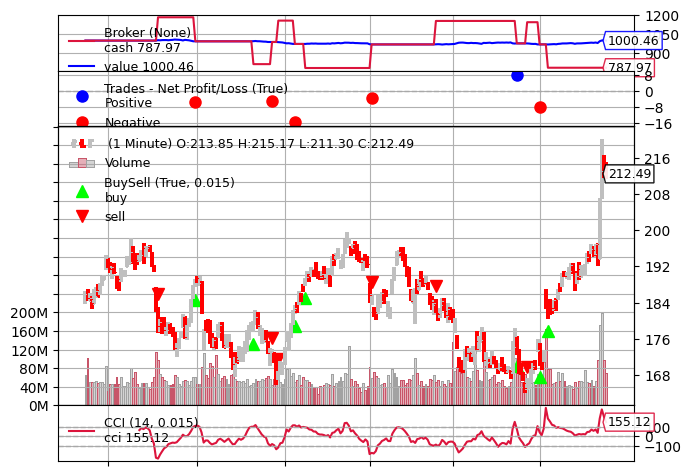

In [18]:
import matplotlib
%matplotlib inline
cerebro, thestrats = run_cerebro(strategy=BackTestStrategy, list_data=data, stake=100, cash=1000)
    #thestrat = thestrats[0]

print("Final Portfolio Value: %.2f" % cerebro.broker.getvalue())
print("Total point return: ", (cerebro.broker.getvalue() - cerebro.broker.startingcash))

# Plot the results
figs = cerebro.plot(
    iplot=False, 
    style="pincandle", width=60 * 10, height=40 * 10
)

In [55]:
from dspy.teleprompt import BootstrapFewShotWithRandomSearch
# @error_tracking_decorator

config = dict(max_bootstrapped_demos=2, max_labeled_demos=4, num_candidate_programs=2, num_threads=6)
teleprompter = BootstrapFewShotWithRandomSearch(metric=validate_answer, **config)
optimized_qa = teleprompter.compile(student=GenerateCodeWithAssert, trainset=dataset.train[:10], valset=dataset.dev[10:15])

TypeError: BaseModule.reset_copy() missing 1 required positional argument: 'self'